# GHI Forecasting using PyTorch Models

This notebook implements deep learning models to forecast Global Horizontal Irradiance (GHI) based on various input features. The notebook is structured as follows:

1. **Data Loading and Exploration**: Load the pre-split train/validation/test datasets and explore their structure
2. **Data Preprocessing**: Prepare the data for model training (normalization, feature engineering)
3. **Model 1: LSTM Network**: Implement a Long Short-Term Memory network for time series forecasting
4. **Model 2: CNN-LSTM**: Implement a hybrid Convolutional-LSTM network
5. **Model 3: Multi-Layer Perceptron**: Implement a deep neural network with multiple linear layers
6. **Model 4: Physics-Informed MLP**: Implement a PINN-based MLP that enforces physical constraints
7. **Model Evaluation**: Compare model performance on validation and test datasets

## 1. Setup and Data Loading

First, let's import the necessary libraries and load the data.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import datetime
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm
import pytz

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Vietnam timezone (UTC+7)
VIETNAM_TZ = pytz.timezone('Asia/Ho_Chi_Minh')

# Function to compute nighttime mask and clear-sky GHI
def compute_physical_constraints(timestamps, coordinates):
    n_times = len(timestamps)
    n_locations = coordinates.shape[0]
    nighttime_mask = np.zeros((n_times, n_locations), dtype=np.float32)
    clear_sky_ghi = np.zeros((n_times, n_locations), dtype=np.float32)
    solar_constant = 1366.1  # W/m²

    for t, timestamp in enumerate(timestamps):
        # Convert UTC+0 to UTC+7
        doy = timestamp.timetuple().tm_yday
        decl = 23.45 * np.sin(2 * np.pi * (doy - 81) / 365)
        decl_rad = np.deg2rad(decl)
        hour = timestamp.hour + timestamp.minute / 60
        ha = (hour - 12) * 15  # Hour angle in degrees
        ha_rad = np.deg2rad(ha)

        for loc in range(n_locations):
            lat, lon = coordinates[loc]
            lat_rad = np.deg2rad(lat)
            cos_theta = np.sin(lat_rad) * np.sin(decl_rad) + np.cos(lat_rad) * np.cos(decl_rad) * np.cos(ha_rad)
            if cos_theta < 0:
                nighttime_mask[t, loc] = 1
            else:
                # Simplified clear-sky GHI (Ineichen-Perez model approximation)
                clear_sky_ghi[t, loc] = solar_constant * cos_theta * 0.7  # Atmospheric transmittance factor

    return nighttime_mask, clear_sky_ghi


Using cuda device


In [2]:
# Define paths to the train, validation and test datasets
train_path = 'data/processed/vietnam2016_time_based_train.h5'
val_path = 'data/processed/vietnam2016_time_based_val.h5'
test_path = 'data/processed/vietnam2016_time_based_test.h5'

# Check if the files exist
for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        print(f"Warning: {path} does not exist!")


### 1.1 Exploring the Data Structure

Let's examine the structure of our H5 files.

In [3]:
def explore_h5_structure(h5_path):
    try:
        with h5py.File(h5_path, 'r') as f:
            print(f"\nExploring {h5_path}")
            print("\nDatasets:")
            for key in f.keys():
                dataset = f[key]
                print(f"  /{key} {dataset.shape}: {dataset.dtype}")
                if len(dataset) > 0 and dataset.ndim > 0:
                    if dataset.dtype in [np.float32, np.float64]:
                        stats = {
                            'min': np.min(dataset[:10]),
                            'max': np.max(dataset[:10]),
                            'mean': np.mean(dataset[:10]),
                            'stddev': np.std(dataset[:10]),
                            'has_nan': np.isnan(dataset[:10]).any()
                        }
                        print(f"    Sample stats: {stats}")
    except Exception as e:
        print(f"Error exploring {h5_path}: {e}")

# Explore data structures
explore_h5_structure(train_path)
explore_h5_structure(val_path)
explore_h5_structure(test_path)



Exploring data/processed/vietnam2016_time_based_train.h5

Datasets:
  /air_temperature (6148, 75361): int8
  /coordinates (75361, 2): float32
    Sample stats: {'min': np.float32(23.55), 'max': np.float32(100.0), 'mean': np.float32(61.8875), 'stddev': np.float32(38.112633), 'has_nan': np.False_}
  /dhi (6148, 75361): int16
  /dni (6148, 75361): int16
  /ghi (6148, 75361): int16
  /meta (75361,): [('gid', '<i4'), ('latitude', '<f4'), ('longitude', '<f4'), ('country', 'S8'), ('timezone', '<i2'), ('elevation', '<f4')]
  /time_index (6148,): |S25
  /wind_speed (6148, 75361): int16

Exploring data/processed/vietnam2016_time_based_val.h5

Datasets:
  /air_temperature (1317, 75361): int8
  /coordinates (75361, 2): float32
    Sample stats: {'min': np.float32(23.55), 'max': np.float32(100.0), 'mean': np.float32(61.8875), 'stddev': np.float32(38.112633), 'has_nan': np.False_}
  /dhi (1317, 75361): int16
  /dni (1317, 75361): int16
  /ghi (1317, 75361): int16
  /meta (75361,): [('gid', '<i4'), 

### 1.2 Data Loading Function

We'll load the data and include the nighttime mask for the PINN model.

In [4]:
def load_data(path, n_samples=1000, random_state=42):
    with h5py.File(path, 'r') as f:
        total_locations = f['coordinates'].shape[0]
        np.random.seed(random_state)
        sampled_indices = np.random.choice(total_locations, min(n_samples, total_locations), replace=False)
        sampled_indices = np.sort(sampled_indices)

        air_temp = f['air_temperature'][:, sampled_indices]
        wind_speed = f['wind_speed'][:, sampled_indices]
        coordinates = f['coordinates'][sampled_indices]
        time_index = f['time_index'][:]
        # Parse the actual timestamps from the file (they are in UTC)
        # First convert bytes to strings
        time_strings = [t.decode('utf-8') for t in time_index]
        # Parse with pandas to preserve timezone information (UTC)
        utc_timestamps = pd.to_datetime(time_strings)
        # Convert UTC to Vietnam local time
        timestamps = [utc_dt.astimezone(VIETNAM_TZ) for utc_dt in utc_timestamps]

        ghi = f['ghi'][:, sampled_indices]

        # Compute nighttime mask for PINN
        nighttime_mask, clear_sky_ghi = compute_physical_constraints(timestamps, coordinates)

        return {
            'air_temperature': air_temp,
            'wind_speed': wind_speed,
            'coordinates': coordinates,
            'time_index': time_index,
            'timestamps': timestamps,
            'ghi': ghi,
            'nighttime_mask': nighttime_mask,
            'clear_sky_ghi': clear_sky_ghi
        }

# Load data
print("Loading training data...")
train_data = load_data(train_path, n_samples=500)
print("Loading validation data...")
val_data = load_data(val_path, n_samples=500)
print("Loading test data...")
test_data = load_data(test_path, n_samples=500)


Loading training data...
Loading validation data...
Loading test data...


### 1.3 Visualize the Data

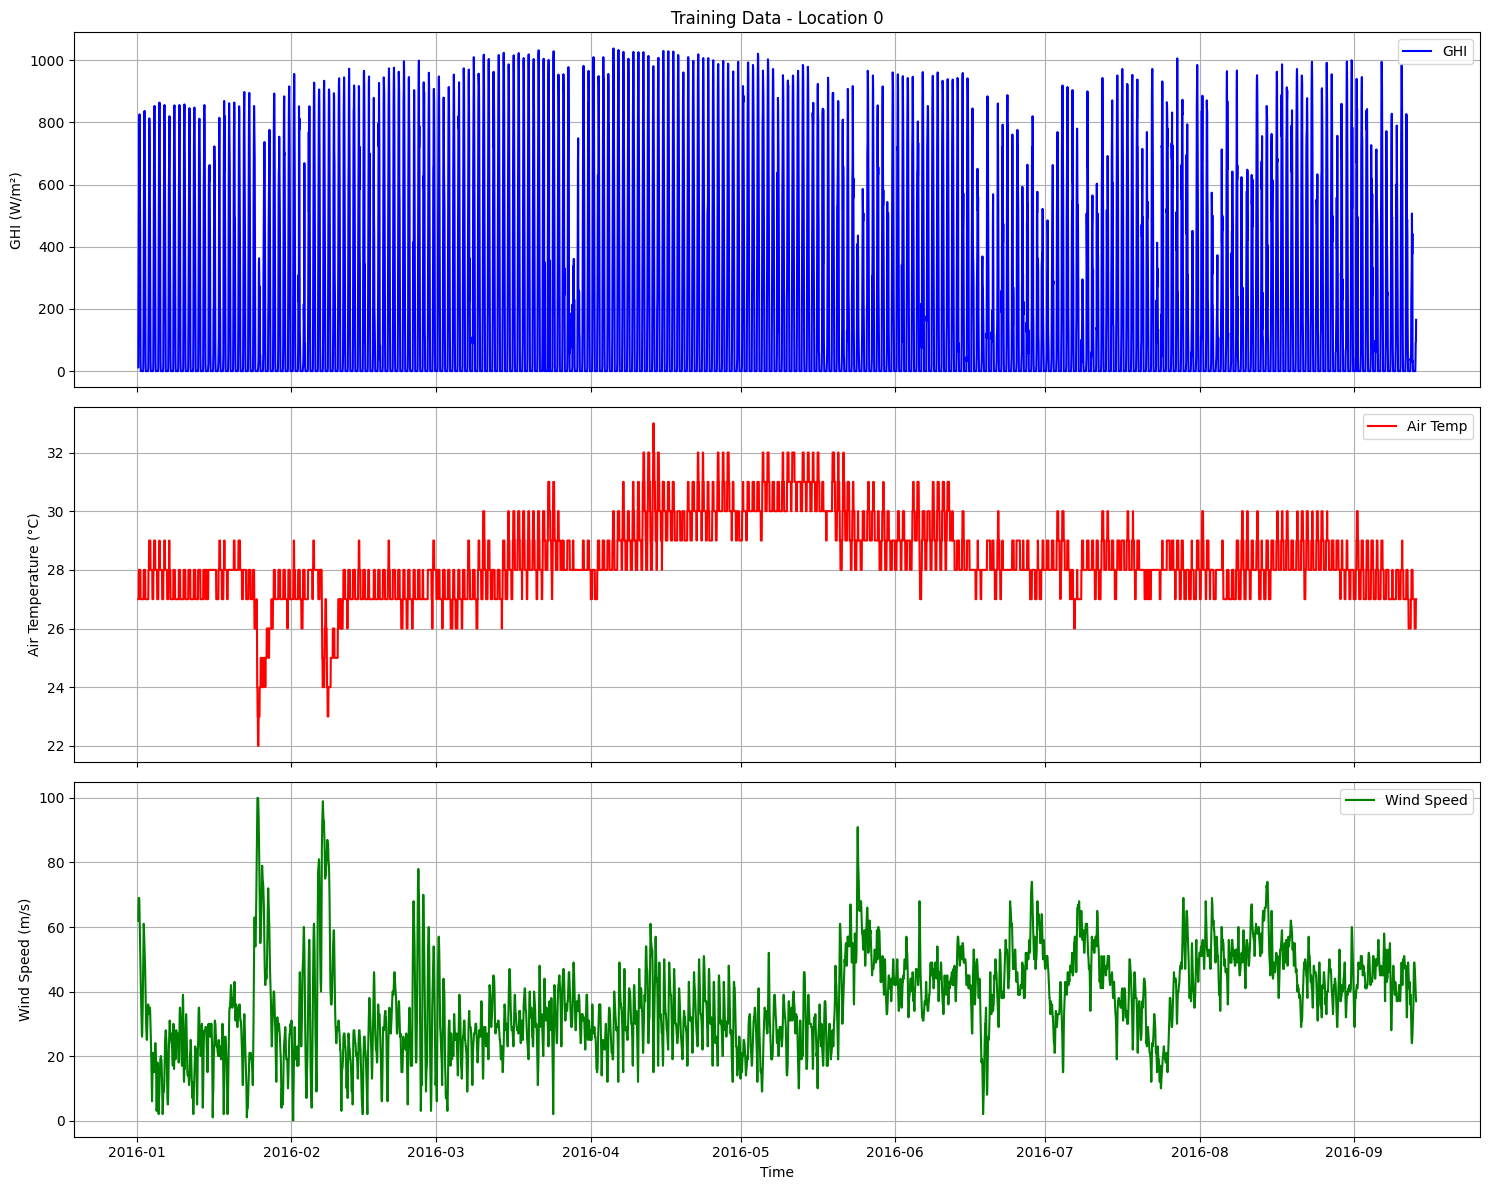

Location coordinates: Latitude 11.3500, Longitude 100.0000


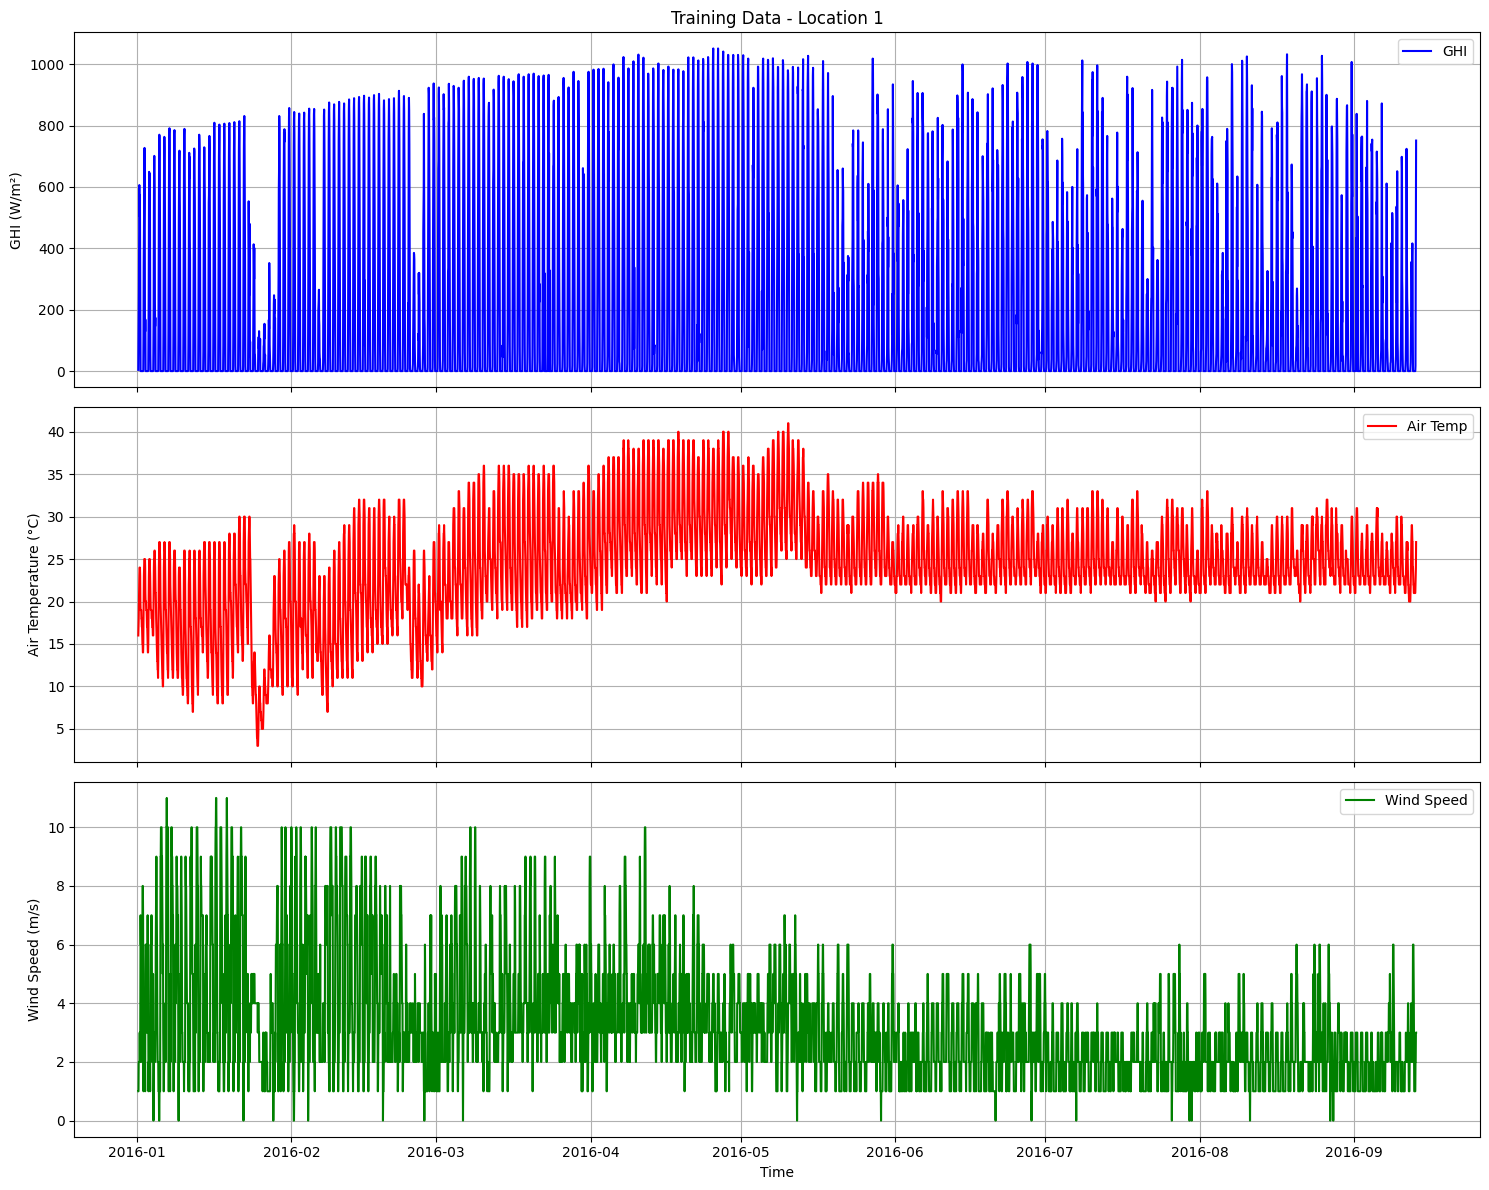

Location coordinates: Latitude 20.5500, Longitude 100.0500


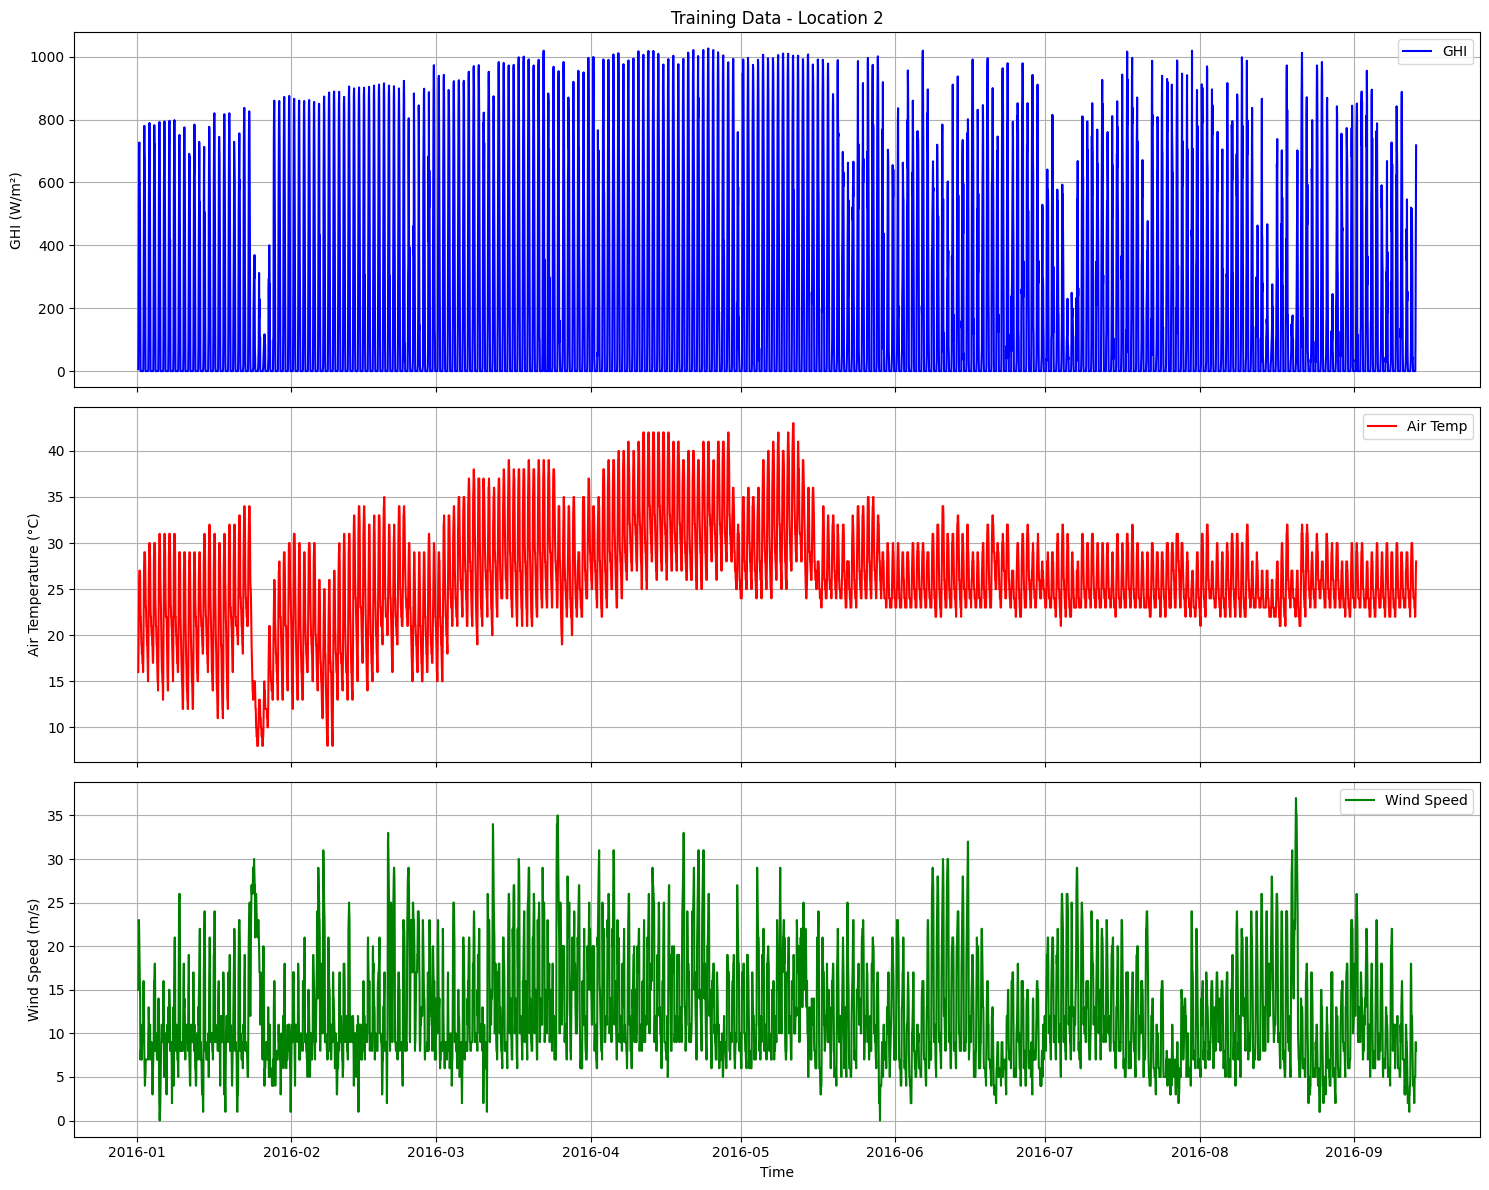

Location coordinates: Latitude 18.3500, Longitude 100.0500


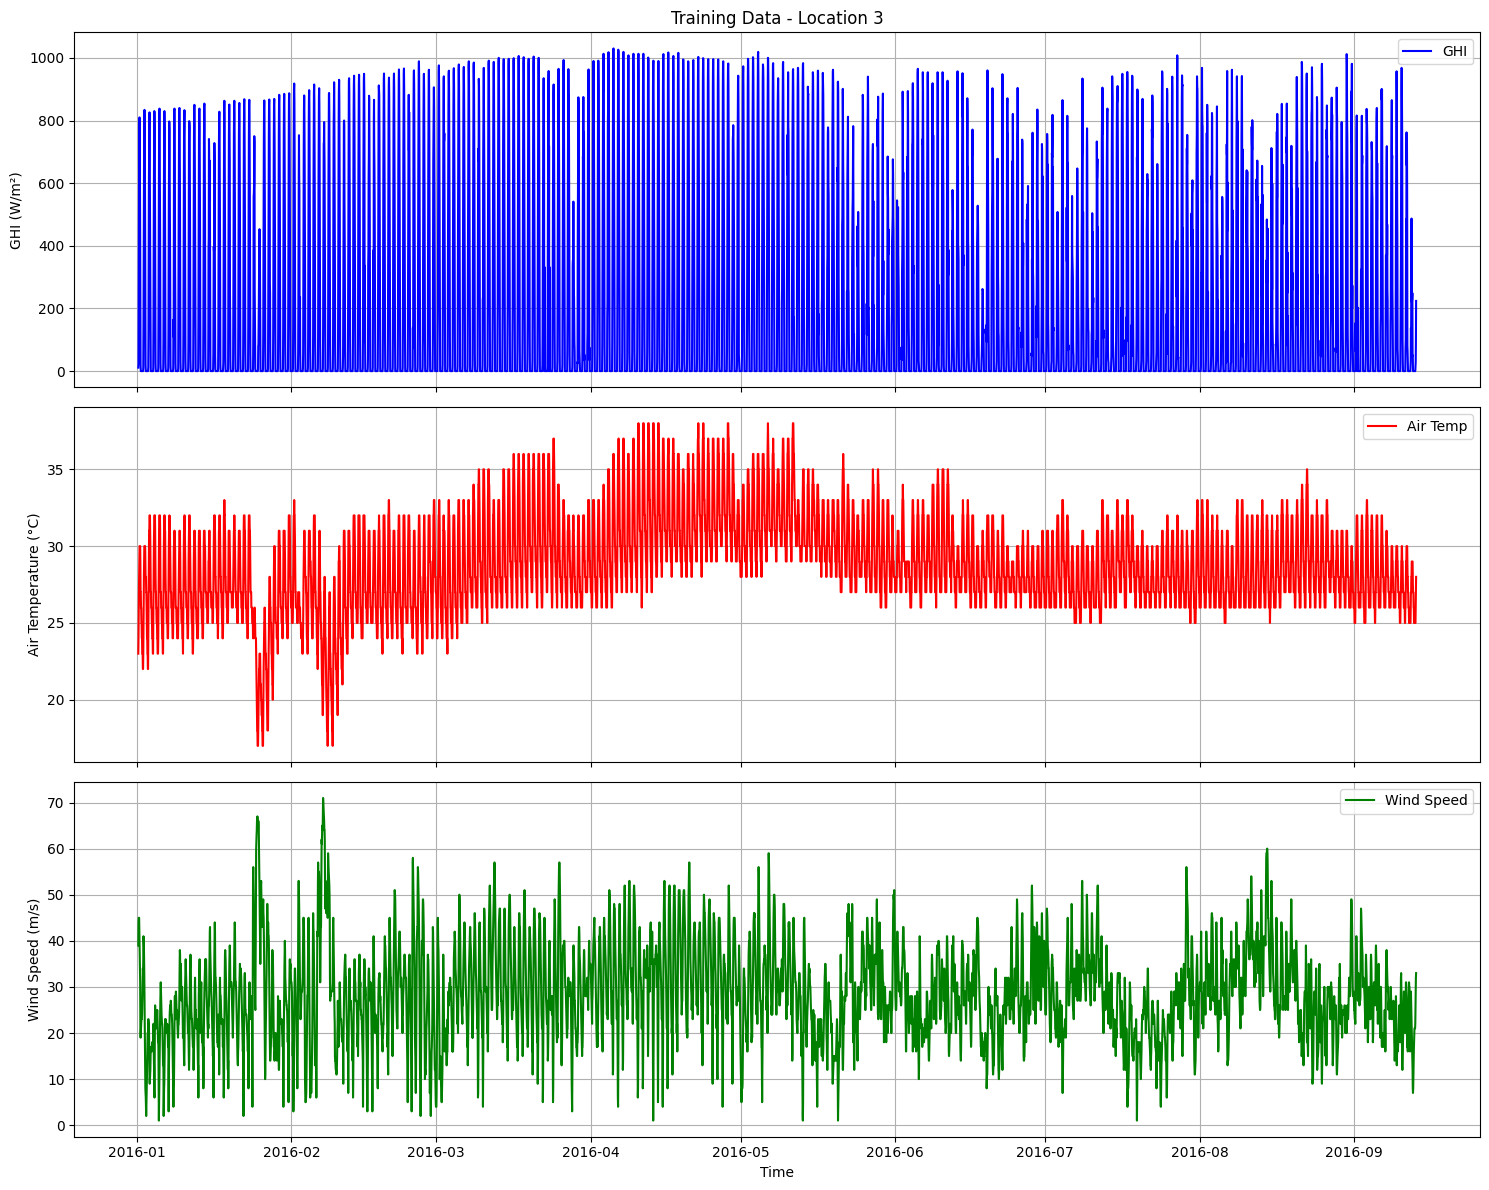

Location coordinates: Latitude 12.8500, Longitude 100.0500


In [5]:
def plot_time_series(data, location_idx=0, title=None):
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

    axes[0].plot(data['timestamps'], data['ghi'][:, location_idx], 'b-', label='GHI')
    axes[0].set_ylabel('GHI (W/m²)')
    axes[0].set_title(title or f'Time Series for Location {location_idx}')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(data['timestamps'], data['air_temperature'][:, location_idx], 'r-', label='Air Temp')
    axes[1].set_ylabel('Air Temperature (°C)')
    axes[1].grid(True)
    axes[1].legend()

    axes[2].plot(data['timestamps'], data['wind_speed'][:, location_idx], 'g-', label='Wind Speed')
    axes[2].set_ylabel('Wind Speed (m/s)')
    axes[2].set_xlabel('Time')
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    lat, lon = data['coordinates'][location_idx]
    print(f"Location coordinates: Latitude {lat:.4f}, Longitude {lon:.4f}")

# Plot data for a few locations
for i in range(4):
    plot_time_series(train_data, location_idx=i, title=f'Training Data - Location {i}')


## 2. Data Preprocessing

### 2.1 Time Feature Engineering

In [6]:
def create_time_features(timestamps):
    hour_of_day = np.array([t.hour for t in timestamps])
    day_of_year = np.array([t.timetuple().tm_yday for t in timestamps])
    month = np.array([t.month for t in timestamps])

    hour_sin = np.sin(2 * np.pi * hour_of_day / 24)
    hour_cos = np.cos(2 * np.pi * hour_of_day / 24)
    day_sin = np.sin(2 * np.pi * day_of_year / 366)
    day_cos = np.cos(2 * np.pi * day_of_year / 366)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    return np.column_stack([hour_sin, hour_cos, day_sin, day_cos, month_sin, month_cos])

train_time_features = create_time_features(train_data['timestamps'])
val_time_features = create_time_features(val_data['timestamps'])
test_time_features = create_time_features(test_data['timestamps'])
print(f"Time features shape: {train_time_features.shape}")


Time features shape: (6148, 6)


### 2.2 Data Normalization

In [7]:
def normalize_data(train_data, val_data, test_data):
    temp_scaler = MinMaxScaler()
    wind_scaler = MinMaxScaler()
    ghi_scaler = MinMaxScaler()
    coord_scaler = MinMaxScaler()
    clear_sky_scaler = MinMaxScaler()

    train_temp = train_data['air_temperature'].reshape(-1, 1)
    train_wind = train_data['wind_speed'].reshape(-1, 1)
    train_ghi = train_data['ghi'].reshape(-1, 1)
    train_clear_sky = train_data['clear_sky_ghi'].reshape(-1, 1)

    temp_scaler.fit(train_temp)
    wind_scaler.fit(train_wind)
    ghi_scaler.fit(train_ghi)
    coord_scaler.fit(train_data['coordinates'])
    clear_sky_scaler.fit(train_clear_sky)

    norm_train_data = {
        'air_temperature': temp_scaler.transform(train_temp).reshape(train_data['air_temperature'].shape),
        'wind_speed': wind_scaler.transform(train_wind).reshape(train_data['wind_speed'].shape),
        'coordinates': coord_scaler.transform(train_data['coordinates']),
        'time_features': train_time_features,
        'ghi': ghi_scaler.transform(train_ghi).reshape(train_data['ghi'].shape),
        'nighttime_mask': train_data['nighttime_mask'],
        'clear_sky_ghi': clear_sky_scaler.transform(train_clear_sky).reshape(train_data['clear_sky_ghi'].shape)
    }

    norm_val_data = {
        'air_temperature': temp_scaler.transform(val_data['air_temperature'].reshape(-1, 1)).reshape(val_data['air_temperature'].shape),
        'wind_speed': wind_scaler.transform(val_data['wind_speed'].reshape(-1, 1)).reshape(val_data['wind_speed'].shape),
        'coordinates': coord_scaler.transform(val_data['coordinates']),
        'time_features': val_time_features,
        'ghi': ghi_scaler.transform(val_data['ghi'].reshape(-1, 1)).reshape(val_data['ghi'].shape),
        'nighttime_mask': val_data['nighttime_mask'],
        'clear_sky_ghi': clear_sky_scaler.transform(val_data['clear_sky_ghi'].reshape(-1, 1)).reshape(val_data['clear_sky_ghi'].shape)
    }

    norm_test_data = {
        'air_temperature': temp_scaler.transform(test_data['air_temperature'].reshape(-1, 1)).reshape(test_data['air_temperature'].shape),
        'wind_speed': wind_scaler.transform(test_data['wind_speed'].reshape(-1, 1)).reshape(test_data['wind_speed'].shape),
        'coordinates': coord_scaler.transform(test_data['coordinates']),
        'time_features': test_time_features,
        'ghi': ghi_scaler.transform(test_data['ghi'].reshape(-1, 1)).reshape(test_data['ghi'].shape),
        'nighttime_mask': test_data['nighttime_mask'],
        'clear_sky_ghi': clear_sky_scaler.transform(test_data['clear_sky_ghi'].reshape(-1, 1)).reshape(test_data['clear_sky_ghi'].shape)
    }

    scalers = {
        'temp_scaler': temp_scaler,
        'wind_scaler': wind_scaler,
        'ghi_scaler': ghi_scaler,
        'coord_scaler': coord_scaler,
        'clear_sky_scaler': clear_sky_scaler
    }
    return norm_train_data, norm_val_data, norm_test_data, scalers

norm_train_data, norm_val_data, norm_test_data, scalers = normalize_data(train_data, val_data, test_data)


### 2.3 Sequence Creation

We'll include the nighttime mask in the sequences for the PINN model.

In [8]:
def create_sequences(data, lookback=24):
    X_temp, X_wind, X_coord, X_time, y, X_target_nighttime, X_clear_sky = [], [], [], [], [], [], []
    n_samples = data['air_temperature'].shape[1]

    for loc in range(n_samples):
        temp = data['air_temperature'][:, loc]
        wind = data['wind_speed'][:, loc]
        ghi = data['ghi'][:, loc]
        coord = data['coordinates'][loc]
        time_feat = data['time_features']
        nighttime_mask = data['nighttime_mask'][:, loc]
        clear_sky = data['clear_sky_ghi'][:, loc]

        for i in range(len(temp) - lookback):
            X_temp.append(temp[i:i+lookback])
            X_wind.append(wind[i:i+lookback])
            X_time.append(time_feat[i:i+lookback])
            X_coord.append(np.tile(coord, (lookback, 1)))
            y.append(ghi[i+lookback])
            X_target_nighttime.append(nighttime_mask[i+lookback])
            X_clear_sky.append(clear_sky[i+lookback])

    return (np.array(X_temp), np.array(X_wind), np.array(X_coord), np.array(X_time),
            np.array(y), np.array(X_target_nighttime), np.array(X_clear_sky))

lookback = 24
train_temp, train_wind, train_coord, train_time, train_y, train_target_nighttime, train_clear_sky = create_sequences(norm_train_data, lookback)
val_temp, val_wind, val_coord, val_time, val_y, val_target_nighttime, val_clear_sky = create_sequences(norm_val_data, lookback)
test_temp, test_wind, test_coord, test_time, test_y, test_target_nighttime, test_clear_sky = create_sequences(norm_test_data, lookback)
print(f"Train shapes: Temp {train_temp.shape}, y {train_y.shape}, Nighttime {train_target_nighttime.shape}, Clear-Sky {train_clear_sky.shape}")


Train shapes: Temp (3062000, 24), y (3062000,), Nighttime (3062000,), Clear-Sky (3062000,)


### 2.4 Create PyTorch Datasets and DataLoaders

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, temp, wind, coord, time, targets, target_nighttime, clear_sky):
        self.temp = torch.tensor(temp, dtype=torch.float32)
        self.wind = torch.tensor(wind, dtype=torch.float32)
        self.coord = torch.tensor(coord, dtype=torch.float32)
        self.time = torch.tensor(time, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)
        self.target_nighttime = torch.tensor(target_nighttime, dtype=torch.float32).unsqueeze(1)
        self.clear_sky = torch.tensor(clear_sky, dtype=torch.float32).unsqueeze(1)

        self.features = torch.cat([self.temp.unsqueeze(2), self.wind.unsqueeze(2), self.time], dim=2)
        self.coord_static = self.coord[:, 0, :]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'coord': self.coord_static[idx],
            'target': self.targets[idx],
            'target_nighttime': self.target_nighttime[idx],
            'clear_sky': self.clear_sky[idx]
        }

train_dataset = TimeSeriesDataset(train_temp, train_wind, train_coord, train_time, train_y, train_target_nighttime, train_clear_sky)
val_dataset = TimeSeriesDataset(val_temp, val_wind, val_coord, val_time, val_y, val_target_nighttime, val_clear_sky)
test_dataset = TimeSeriesDataset(test_temp, test_wind, test_coord, test_time, test_y, test_target_nighttime, test_clear_sky)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

for batch in train_loader:
    print(f"Features shape: {batch['features'].shape}, Target shape: {batch['target'].shape}, "
          f"Nighttime shape: {batch['target_nighttime'].shape}, Clear-Sky shape: {batch['clear_sky'].shape}")
    break


Features shape: torch.Size([64, 24, 8]), Target shape: torch.Size([64, 1]), Nighttime shape: torch.Size([64, 1]), Clear-Sky shape: torch.Size([64, 1])


## 3. Model Implementations

### 3.1 LSTM Model

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, coord_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.coord_proj = nn.Sequential(nn.Linear(coord_dim, 16), nn.BatchNorm1d(16), nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(hidden_dim + 16, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(dropout), nn.Linear(32, 1))

    def forward(self, x, coord):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.bn1(lstm_out)
        coord_out = self.coord_proj(coord)
        combined = torch.cat([lstm_out, coord_out], dim=1)
        return self.fc(combined)

input_dim = train_dataset.features.shape[2]
coord_dim = train_dataset.coord_static.shape[1]
lstm_model = LSTMModel(input_dim=input_dim, coord_dim=coord_dim, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
print(lstm_model)


LSTMModel(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.3)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (coord_proj): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


### 3.2 CNN-LSTM Model

In [11]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, coord_dim, hidden_dim=64, num_filters=64, num_layers=1, dropout=0.2):
        super(CNNLSTMModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, num_filters, kernel_size=3, padding=1),
            nn.BatchNorm1d(num_filters),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(num_filters, num_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm1d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        cnn_output_dim = num_filters * 2
        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.bn_lstm = nn.BatchNorm1d(hidden_dim)
        self.coord_proj = nn.Sequential(nn.Linear(coord_dim, 16), nn.BatchNorm1d(16), nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(hidden_dim + 16, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(dropout), nn.Linear(32, 1))

    def forward(self, x, coord):
        x = x.permute(0, 2, 1)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.bn_lstm(lstm_out)
        coord_out = self.coord_proj(coord)
        combined = torch.cat([lstm_out, coord_out], dim=1)
        return self.fc(combined)

cnn_lstm_model = CNNLSTMModel(input_dim=input_dim, coord_dim=coord_dim, hidden_dim=64, num_filters=64, num_layers=1, dropout=0.3).to(device)
print(cnn_lstm_model)


CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 64, batch_first=True)
  (bn_lstm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (coord_proj): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-0

### 3.3 Multi-Layer Perceptron (MLP) Model

In [12]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, coord_dim, hidden_dims=[128, 256, 128, 64], dropout=0.3):
        super(MLPModel, self).__init__()
        self.flatten_dim = input_dim * lookback
        layers = [nn.Linear(self.flatten_dim, hidden_dims[0]), nn.BatchNorm1d(hidden_dims[0]), nn.Tanh(), nn.Dropout(dropout)]
        for i in range(len(hidden_dims)-1):
            layers.extend([nn.Linear(hidden_dims[i], hidden_dims[i+1]), nn.BatchNorm1d(hidden_dims[i+1]), nn.Tanh(), nn.Dropout(dropout)])
        self.mlp = nn.Sequential(*layers)
        self.coord_proj = nn.Sequential(nn.Linear(coord_dim, 16), nn.BatchNorm1d(16), nn.Tanh())
        self.fc = nn.Sequential(nn.Linear(hidden_dims[-1] + 16, 32), nn.BatchNorm1d(32), nn.Tanh(), nn.Dropout(dropout), nn.Linear(32, 1))

    def forward(self, x, coord):
        batch_size = x.shape[0]
        x_flat = x.reshape(batch_size, -1)
        mlp_out = self.mlp(x_flat)
        coord_out = self.coord_proj(coord)
        combined = torch.cat([mlp_out, coord_out], dim=1)
        return self.fc(combined)

mlp_model = MLPModel(input_dim=input_dim, coord_dim=coord_dim, hidden_dims=[256, 512, 256, 128], dropout=0.3).to(device)
print(mlp_model)


MLPModel(
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Tanh()
    (15): Dropout(p=0.3, inplace=False)
  )
  (coord_proj): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum

### 3.4 Physics-Informed MLP Model

We use the same MLP architecture but will train it with a physics-informed loss to enforce zero GHI during nighttime.

In [13]:
pinn_mlp_model = MLPModel(input_dim=input_dim, coord_dim=coord_dim, hidden_dims=[256, 512, 256, 128], dropout=0.3).to(device)
print(pinn_mlp_model)


MLPModel(
  (mlp): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Tanh()
    (15): Dropout(p=0.3, inplace=False)
  )
  (coord_proj): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum

## 4. Model Training and Evaluation

In [14]:
def train_model(model, train_loader, val_loader, epochs=100, patience=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        for batch in train_loader:
            features = batch['features'].to(device)
            coord = batch['coord'].to(device)
            target = batch['target'].to(device)

            optimizer.zero_grad()
            output = model(features, coord)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * features.size(0)
            train_mae += F.l1_loss(output, target, reduction='sum').item()

        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                coord = batch['coord'].to(device)
                target = batch['target'].to(device)
                output = model(features, coord)
                loss = criterion(output, target)
                val_loss += loss.item() * features.size(0)
                val_mae += F.l1_loss(output, target, reduction='sum').item()

        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)

        scheduler.step(val_loss)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f} | Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    return history

def train_pinn_model(model, train_loader, val_loader, epochs=50, patience=10, lr=0.001,
                     lambda_night=1.0, lambda_neg=0.5, lambda_clear=0.1):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        train_loss = 0.0
        train_mae = 0.0

        for batch in train_loader:
            features = batch['features'].to(device)
            coord = batch['coord'].to(device)
            target = batch['target'].to(device)
            target_nighttime = batch['target_nighttime'].to(device)
            clear_sky = batch['clear_sky'].to(device)

            optimizer.zero_grad()
            output = model(features, coord)

            # Data loss
            mse_loss = criterion(output, target)

            # Nighttime loss (GHI = 0 when nighttime_mask = 1)
            night_loss = torch.mean((output * target_nighttime) ** 2)

            # Non-negativity loss (penalize GHI < 0)
            neg_loss = torch.mean(torch.relu(-output) ** 2)

            # Clear-sky loss (align with clear-sky GHI during daytime)
            clear_mask = 1 - target_nighttime
            clear_loss = torch.mean((clear_mask * (output - clear_sky)) ** 2)

            # Total loss
            total_loss = mse_loss + lambda_night * night_loss + lambda_neg * neg_loss + lambda_clear * clear_loss

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item() * features.size(0)
            train_mae += torch.abs(output - target).sum().item()

        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_mae = 0.0

        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                coord = batch['coord'].to(device)
                target = batch['target'].to(device)
                target_nighttime = batch['target_nighttime'].to(device)
                clear_sky = batch['clear_sky'].to(device)

                output = model(features, coord)
                mse_loss = criterion(output, target)
                night_loss = torch.mean((output * target_nighttime) ** 2)
                neg_loss = torch.mean(torch.relu(-output) ** 2)
                clear_mask = 1 - target_nighttime
                clear_loss = torch.mean((clear_mask * (output - clear_sky)) ** 2)
                total_loss = mse_loss + lambda_night * night_loss + lambda_neg * neg_loss + lambda_clear * clear_loss

                val_loss += total_loss.item() * features.size(0)
                val_mae += torch.abs(output - target).sum().item()

        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)

        scheduler.step(val_loss)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    return history

def evaluate_model(model, data_loader, scaler):
    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            features = batch['features'].to(device)
            coord = batch['coord'].to(device)
            target = batch['target'].to(device)
            output = model(features, coord)
            all_outputs.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    all_outputs = np.vstack(all_outputs)
    all_targets = np.vstack(all_targets)
    y_pred_orig = scaler.inverse_transform(all_outputs)
    y_true_orig = scaler.inverse_transform(all_targets)

    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)

    print(f"Evaluation Metrics:\n  MSE: {mse:.2f}\n  RMSE: {rmse:.2f}\n  MAE: {mae:.2f}\n  R²: {r2:.4f}")
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'y_pred': y_pred_orig, 'y_true': y_true_orig}

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_mae'], label='Train')
    plt.plot(history['val_mae'], label='Validation')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(metrics, model_name=''):
    residuals = metrics['y_true'] - metrics['y_pred']
    plt.figure(figsize=(15, 10))

    sample_size = min(1000, len(metrics['y_true']))
    sample_indices = np.random.choice(len(metrics['y_true']), sample_size, replace=False)

    plt.subplot(2, 2, 1)
    plt.scatter(metrics['y_true'][sample_indices], metrics['y_pred'][sample_indices], alpha=0.5)
    plt.plot([metrics['y_true'].min(), metrics['y_true'].max()], [metrics['y_true'].min(), metrics['y_true'].max()], 'r--')
    plt.title(f'{model_name} - Actual vs Predicted GHI')
    plt.xlabel('Actual GHI (W/m²)')
    plt.ylabel('Predicted GHI (W/m²)')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'{model_name} - Residuals Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.scatter(metrics['y_pred'][sample_indices], residuals[sample_indices], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{model_name} - Residuals vs Predicted')
    plt.xlabel('Predicted GHI (W/m²)')
    plt.ylabel('Residual')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.axis('off')
    stats_text = f"Metrics:\nMSE: {metrics['mse']:.2f}\nRMSE: {metrics['rmse']:.2f}\nMAE: {metrics['mae']:.2f}\nR²: {metrics['r2']:.4f}\n\n"
    stats_text += f"Residual Stats:\nMean: {np.mean(residuals):.2f}\nStd: {np.std(residuals):.2f}"
    plt.text(0.1, 0.5, stats_text, fontsize=12)

    plt.tight_layout()
    plt.show()


## 5. Train and Evaluate Models

### 5.4 Train and Evaluate PINN-MLP Model

Training PINN-MLP model...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0192, Train MAE: 0.0814 | Val Loss: 0.0171, Val MAE: 0.0669 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.0165, Train MAE: 0.0732 | Val Loss: 0.0180, Val MAE: 0.0813 | LR: 0.001000
Epoch 3/50 | Train Loss: 0.0160, Train MAE: 0.0718 | Val Loss: 0.0176, Val MAE: 0.0676 | LR: 0.001000
Epoch 4/50 | Train Loss: 0.0159, Train MAE: 0.0712 | Val Loss: 0.0175, Val MAE: 0.0665 | LR: 0.001000
Epoch 5/50 | Train Loss: 0.0157, Train MAE: 0.0708 | Val Loss: 0.0177, Val MAE: 0.0666 | LR: 0.001000
Epoch 6/50 | Train Loss: 0.0156, Train MAE: 0.0705 | Val Loss: 0.0168, Val MAE: 0.0648 | LR: 0.001000
Epoch 7/50 | Train Loss: 0.0156, Train MAE: 0.0703 | Val Loss: 0.0175, Val MAE: 0.0664 | LR: 0.001000
Epoch 8/50 | Train Loss: 0.0155, Train MAE: 0.0701 | Val Loss: 0.0173, Val MAE: 0.0691 | LR: 0.001000
Epoch 9/50 | Train Loss: 0.0154, Train MAE: 0.0699 | Val Loss: 0.0172, Val MAE: 0.0654 | LR: 0.001000
Epoch 10/50 | Train Loss: 0.0154, Train MAE: 0.0697 | Val Loss: 0.0174, Val MAE: 0

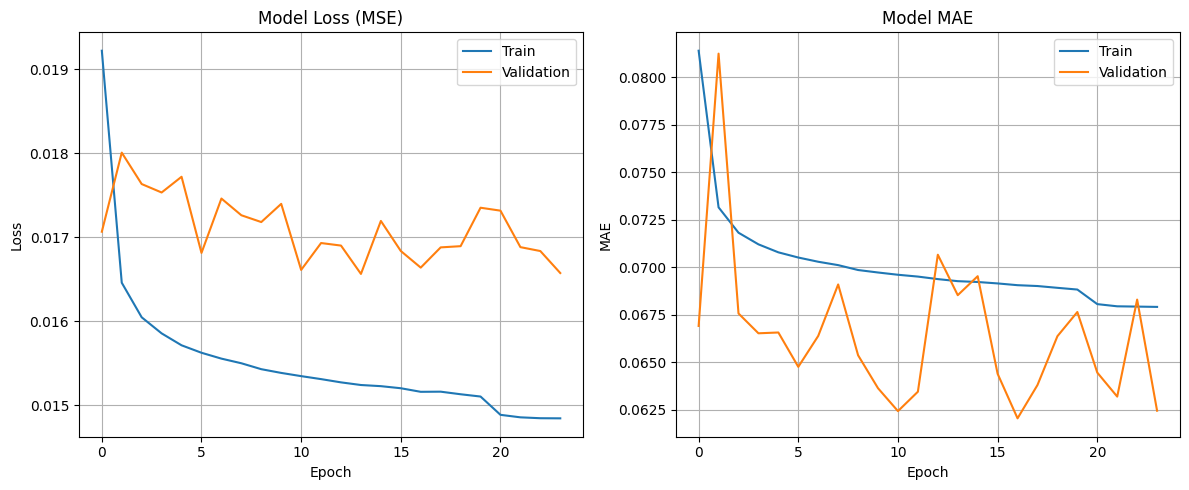

Evaluating PINN-MLP model on validation set...
Evaluation Metrics:
  MSE: 15403.02
  RMSE: 124.11
  MAE: 67.76
  R²: 0.7926


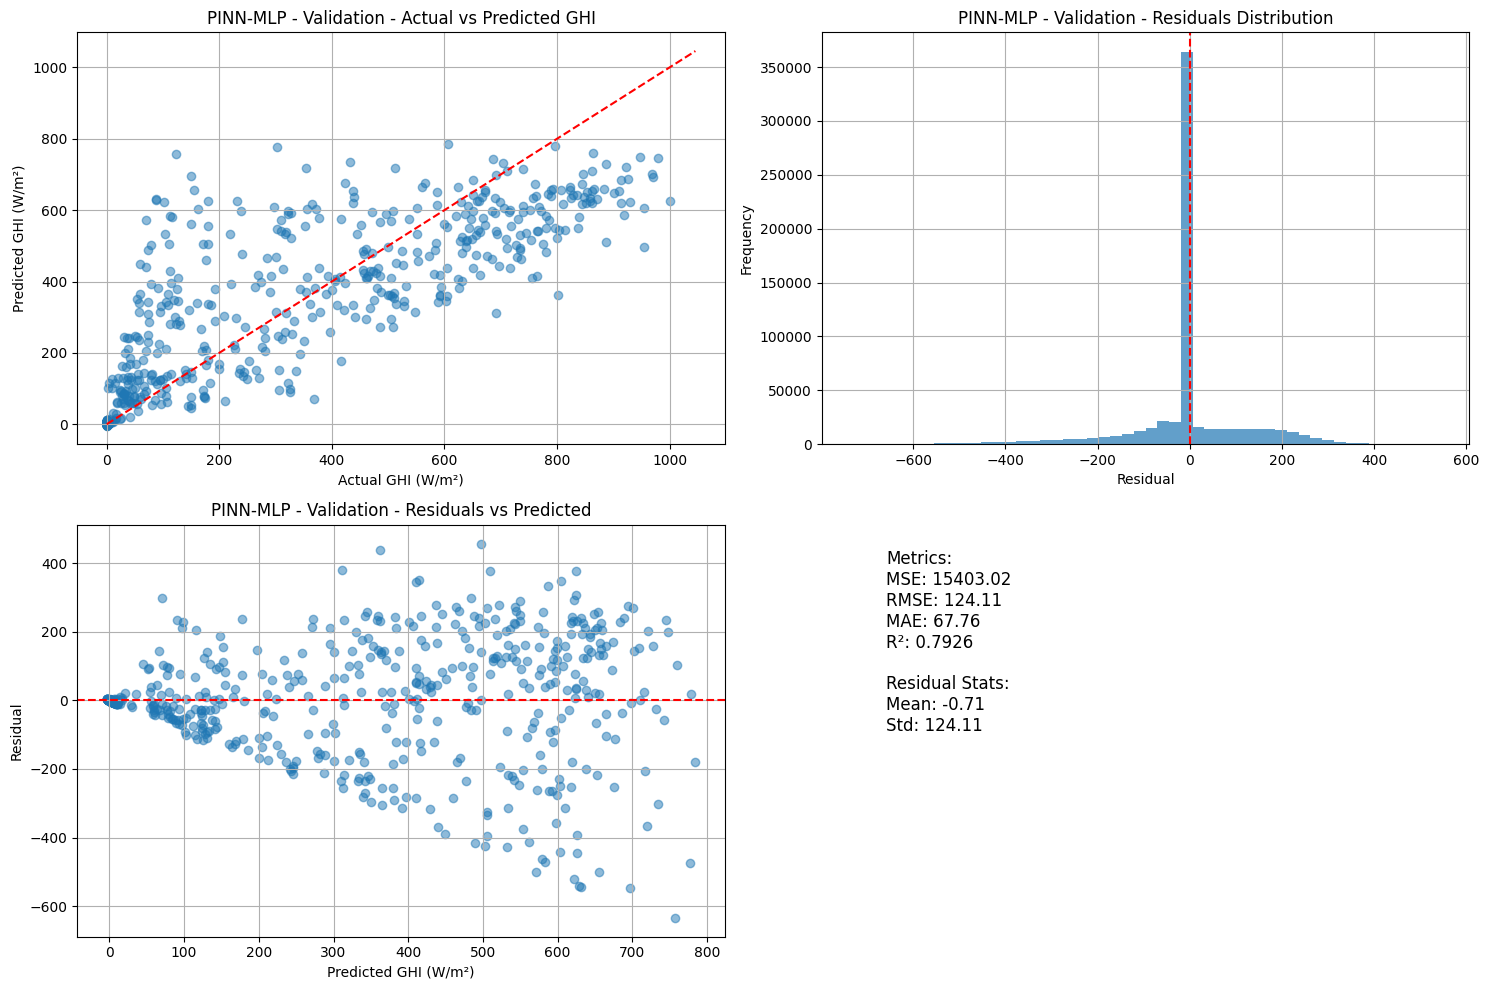


Evaluating PINN-MLP model on test set...
Evaluation Metrics:
  MSE: 11531.66
  RMSE: 107.39
  MAE: 57.13
  R²: 0.8180


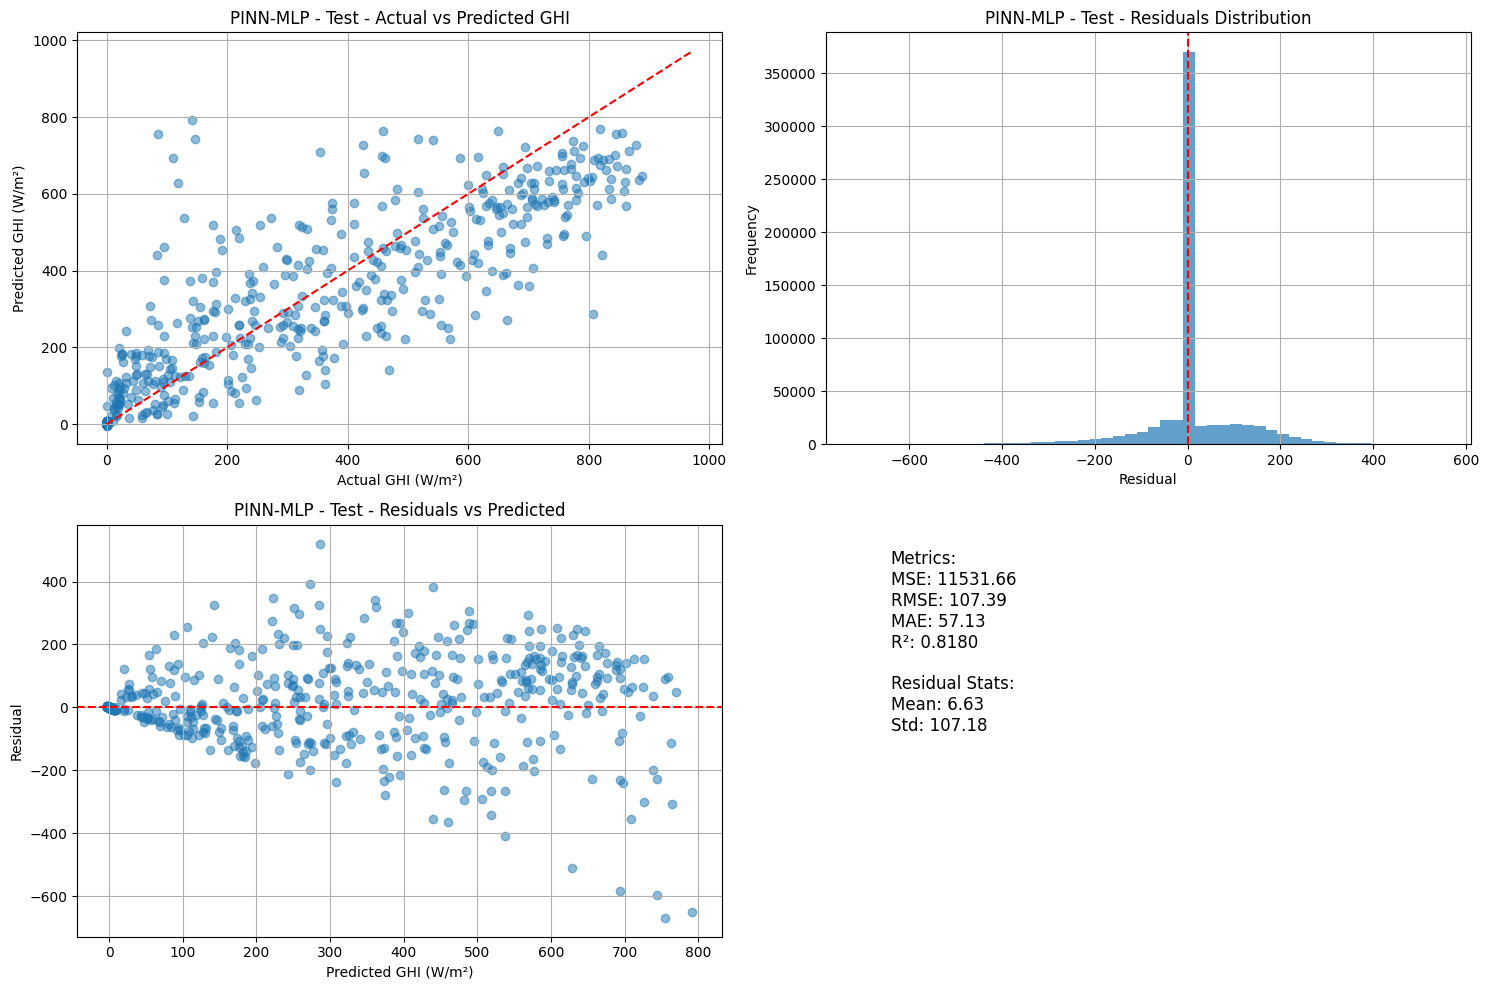

In [15]:
print("Training PINN-MLP model...")
pinn_mlp_history = train_pinn_model(pinn_mlp_model, train_loader, val_loader, epochs=50, patience=10, lr=0.001, 
                                    lambda_night=1.0, lambda_neg=0.5, lambda_clear=0.1)
plot_training_history(pinn_mlp_history)

print("Evaluating PINN-MLP model on validation set...")
pinn_mlp_val_metrics = evaluate_model(pinn_mlp_model, val_loader, scalers['ghi_scaler'])
plot_predictions(pinn_mlp_val_metrics, model_name='PINN-MLP - Validation')

print("\nEvaluating PINN-MLP model on test set...")
pinn_mlp_test_metrics = evaluate_model(pinn_mlp_model, test_loader, scalers['ghi_scaler'])
plot_predictions(pinn_mlp_test_metrics, model_name='PINN-MLP - Test')


### 5.1 Train and Evaluate LSTM Model

Training LSTM model...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0135, Train MAE: 0.0740 | Val Loss: 0.0176, Val MAE: 0.0805 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.0117, Train MAE: 0.0681 | Val Loss: 0.0197, Val MAE: 0.0810 | LR: 0.001000
Epoch 3/50 | Train Loss: 0.0112, Train MAE: 0.0664 | Val Loss: 0.0148, Val MAE: 0.0680 | LR: 0.001000
Epoch 4/50 | Train Loss: 0.0109, Train MAE: 0.0654 | Val Loss: 0.0135, Val MAE: 0.0635 | LR: 0.001000
Epoch 5/50 | Train Loss: 0.0107, Train MAE: 0.0646 | Val Loss: 0.0141, Val MAE: 0.0681 | LR: 0.001000
Epoch 6/50 | Train Loss: 0.0104, Train MAE: 0.0639 | Val Loss: 0.0152, Val MAE: 0.0691 | LR: 0.001000
Epoch 7/50 | Train Loss: 0.0103, Train MAE: 0.0634 | Val Loss: 0.0155, Val MAE: 0.0683 | LR: 0.001000
Epoch 8/50 | Train Loss: 0.0101, Train MAE: 0.0629 | Val Loss: 0.0157, Val MAE: 0.0686 | LR: 0.001000
Epoch 9/50 | Train Loss: 0.0100, Train MAE: 0.0626 | Val Loss: 0.0157, Val MAE: 0.0698 | LR: 0.001000
Epoch 10/50 | Train Loss: 0.0099, Train MAE: 0.0623 | Val Loss: 0.0164, Val MAE: 0

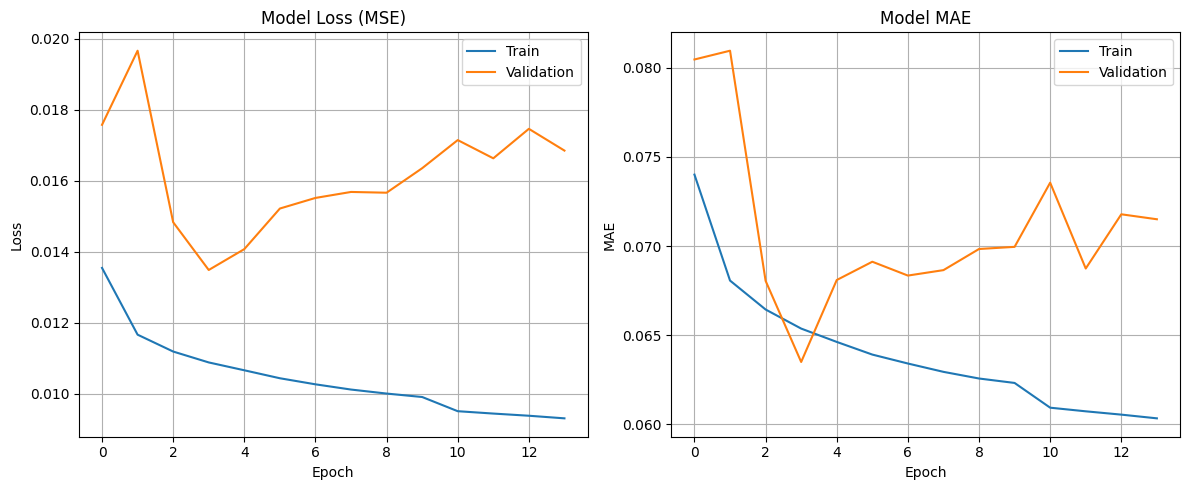

Evaluating LSTM model on validation set...
Evaluation Metrics:
  MSE: 19833.58
  RMSE: 140.83
  MAE: 77.58
  R²: 0.7329


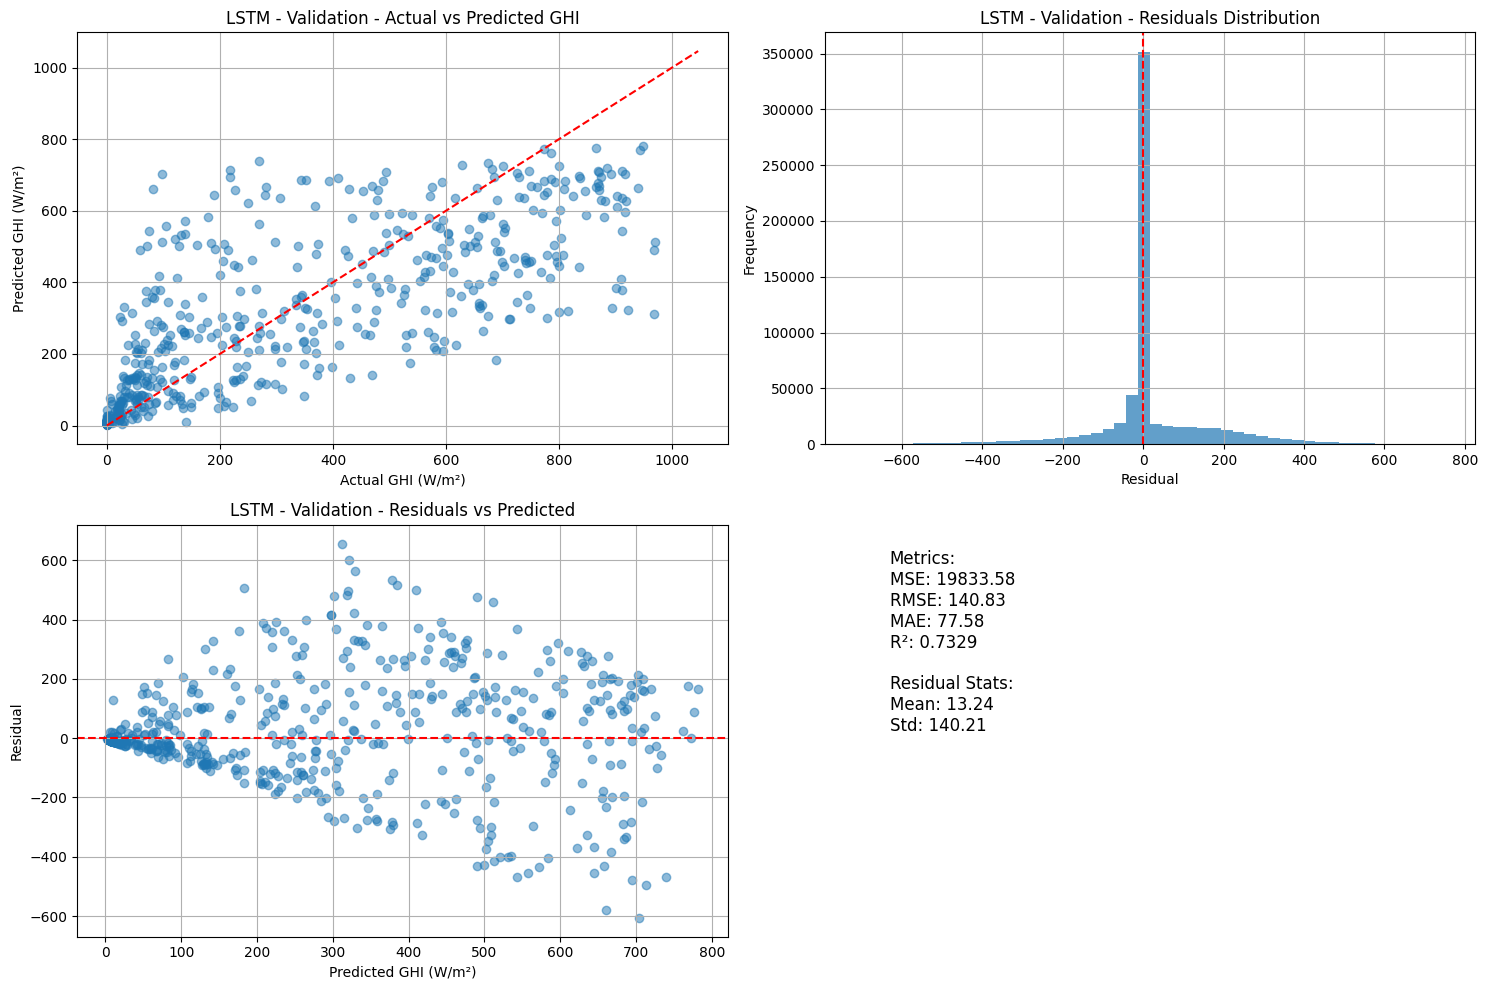


Evaluating LSTM model on test set...
Evaluation Metrics:
  MSE: 16327.92
  RMSE: 127.78
  MAE: 71.24
  R²: 0.7423


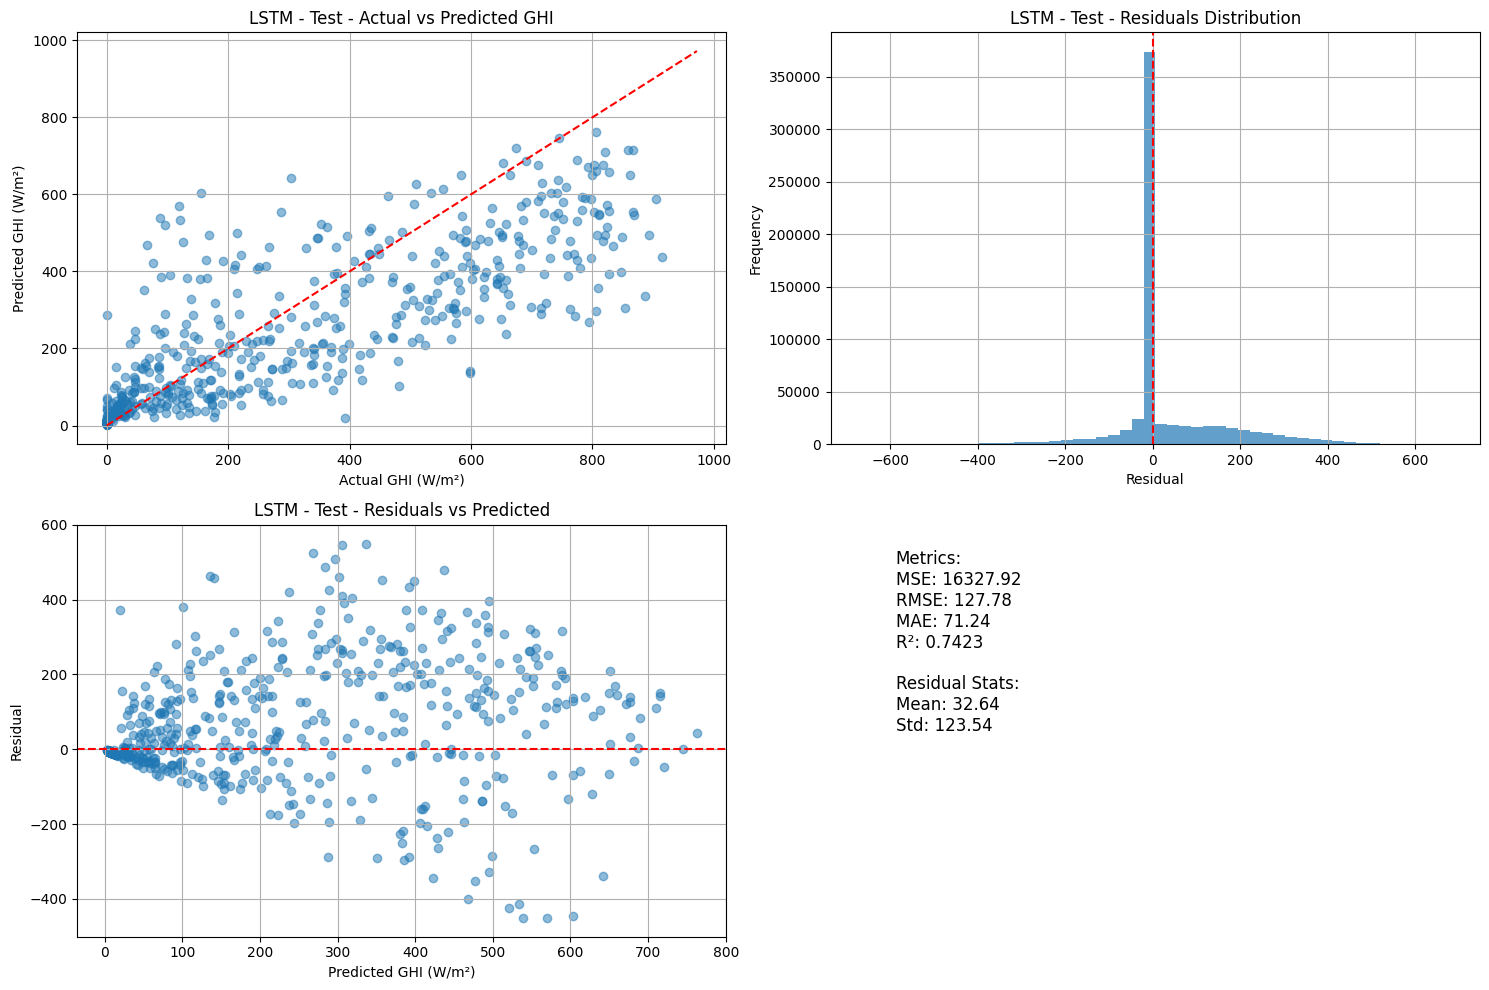

In [16]:
print("Training LSTM model...")
lstm_history = train_model(lstm_model, train_loader, val_loader, epochs=50, patience=10, lr=0.001)
plot_training_history(lstm_history)

print("Evaluating LSTM model on validation set...")
lstm_val_metrics = evaluate_model(lstm_model, val_loader, scalers['ghi_scaler'])
plot_predictions(lstm_val_metrics, model_name='LSTM - Validation')

print("\nEvaluating LSTM model on test set...")
lstm_test_metrics = evaluate_model(lstm_model, test_loader, scalers['ghi_scaler'])
plot_predictions(lstm_test_metrics, model_name='LSTM - Test')


### 5.2 Train and Evaluate CNN-LSTM Model

Training CNN-LSTM model...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0124, Train MAE: 0.0715 | Val Loss: 0.0165, Val MAE: 0.0897 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.0110, Train MAE: 0.0662 | Val Loss: 0.0155, Val MAE: 0.0772 | LR: 0.001000
Epoch 3/50 | Train Loss: 0.0105, Train MAE: 0.0647 | Val Loss: 0.0168, Val MAE: 0.0766 | LR: 0.001000
Epoch 4/50 | Train Loss: 0.0103, Train MAE: 0.0640 | Val Loss: 0.0150, Val MAE: 0.0703 | LR: 0.001000
Epoch 5/50 | Train Loss: 0.0101, Train MAE: 0.0634 | Val Loss: 0.0151, Val MAE: 0.0729 | LR: 0.001000
Epoch 6/50 | Train Loss: 0.0100, Train MAE: 0.0629 | Val Loss: 0.0152, Val MAE: 0.0709 | LR: 0.001000
Epoch 7/50 | Train Loss: 0.0098, Train MAE: 0.0625 | Val Loss: 0.0168, Val MAE: 0.0737 | LR: 0.001000
Epoch 8/50 | Train Loss: 0.0098, Train MAE: 0.0623 | Val Loss: 0.0143, Val MAE: 0.0685 | LR: 0.001000
Epoch 9/50 | Train Loss: 0.0097, Train MAE: 0.0619 | Val Loss: 0.0150, Val MAE: 0.0703 | LR: 0.001000
Epoch 10/50 | Train Loss: 0.0096, Train MAE: 0.0618 | Val Loss: 0.0151, Val MAE: 0

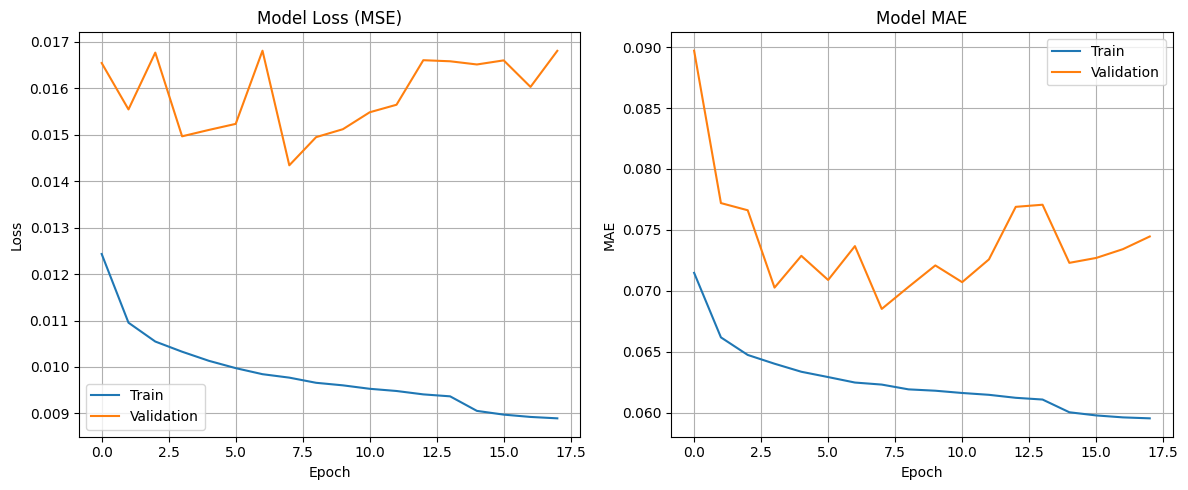

Evaluating CNN-LSTM model on validation set...
Evaluation Metrics:
  MSE: 19788.80
  RMSE: 140.67
  MAE: 80.79
  R²: 0.7335


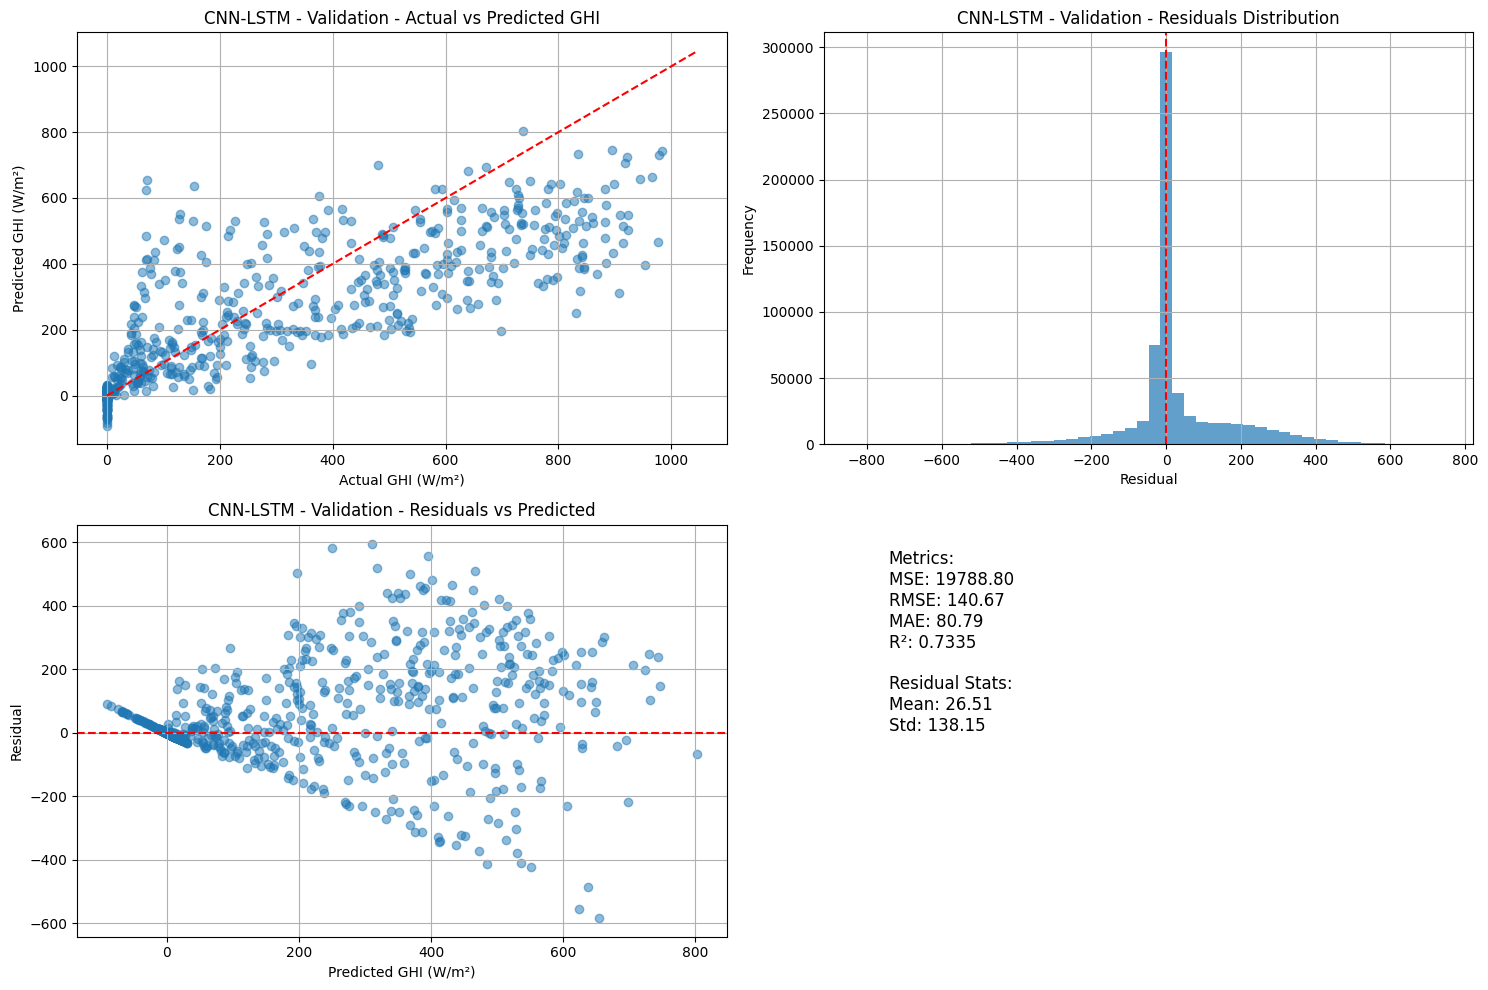


Evaluating CNN-LSTM model on test set...
Evaluation Metrics:
  MSE: 13802.75
  RMSE: 117.49
  MAE: 65.16
  R²: 0.7822


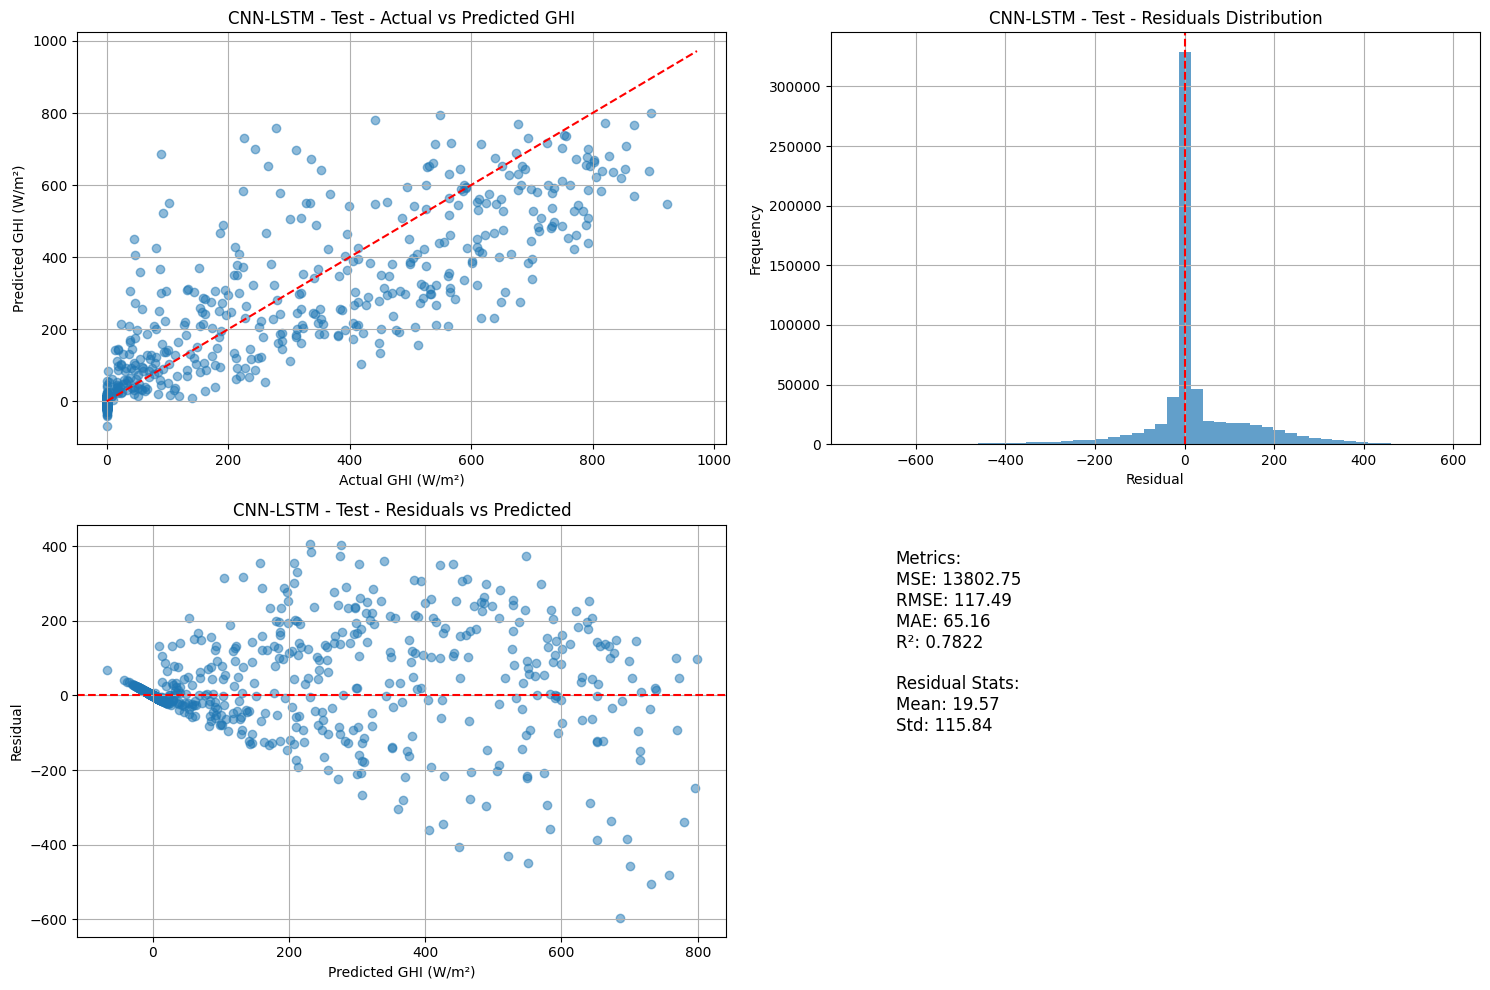

In [17]:
print("Training CNN-LSTM model...")
cnn_lstm_history = train_model(cnn_lstm_model, train_loader, val_loader, epochs=50, patience=10, lr=0.001)
plot_training_history(cnn_lstm_history)

print("Evaluating CNN-LSTM model on validation set...")
cnn_lstm_val_metrics = evaluate_model(cnn_lstm_model, val_loader, scalers['ghi_scaler'])
plot_predictions(cnn_lstm_val_metrics, model_name='CNN-LSTM - Validation')

print("\nEvaluating CNN-LSTM model on test set...")
cnn_lstm_test_metrics = evaluate_model(cnn_lstm_model, test_loader, scalers['ghi_scaler'])
plot_predictions(cnn_lstm_test_metrics, model_name='CNN-LSTM - Test')


### 5.3 Train and Evaluate MLP Model

Training MLP model...


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0150, Train MAE: 0.0838 | Val Loss: 0.0149, Val MAE: 0.0688 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.0127, Train MAE: 0.0752 | Val Loss: 0.0151, Val MAE: 0.0766 | LR: 0.001000
Epoch 3/50 | Train Loss: 0.0122, Train MAE: 0.0734 | Val Loss: 0.0136, Val MAE: 0.0649 | LR: 0.001000
Epoch 4/50 | Train Loss: 0.0120, Train MAE: 0.0726 | Val Loss: 0.0148, Val MAE: 0.0706 | LR: 0.001000
Epoch 5/50 | Train Loss: 0.0118, Train MAE: 0.0720 | Val Loss: 0.0135, Val MAE: 0.0649 | LR: 0.001000
Epoch 6/50 | Train Loss: 0.0117, Train MAE: 0.0717 | Val Loss: 0.0145, Val MAE: 0.0678 | LR: 0.001000
Epoch 7/50 | Train Loss: 0.0117, Train MAE: 0.0714 | Val Loss: 0.0147, Val MAE: 0.0716 | LR: 0.001000
Epoch 8/50 | Train Loss: 0.0116, Train MAE: 0.0712 | Val Loss: 0.0151, Val MAE: 0.0689 | LR: 0.001000
Epoch 9/50 | Train Loss: 0.0115, Train MAE: 0.0710 | Val Loss: 0.0145, Val MAE: 0.0735 | LR: 0.001000
Epoch 10/50 | Train Loss: 0.0115, Train MAE: 0.0708 | Val Loss: 0.0153, Val MAE: 0

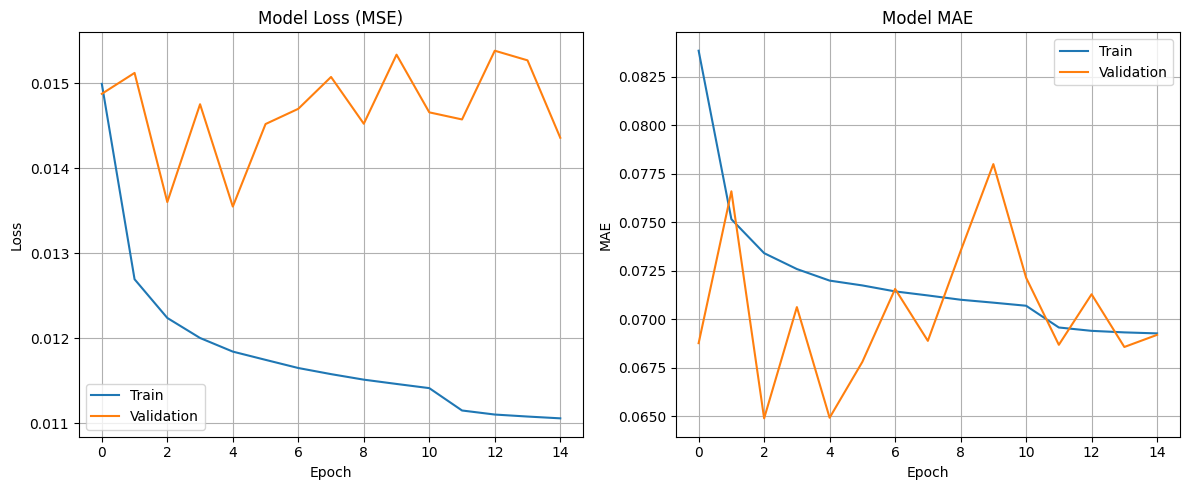

Evaluating MLP model on validation set...
Evaluation Metrics:
  MSE: 16902.71
  RMSE: 130.01
  MAE: 75.07
  R²: 0.7724


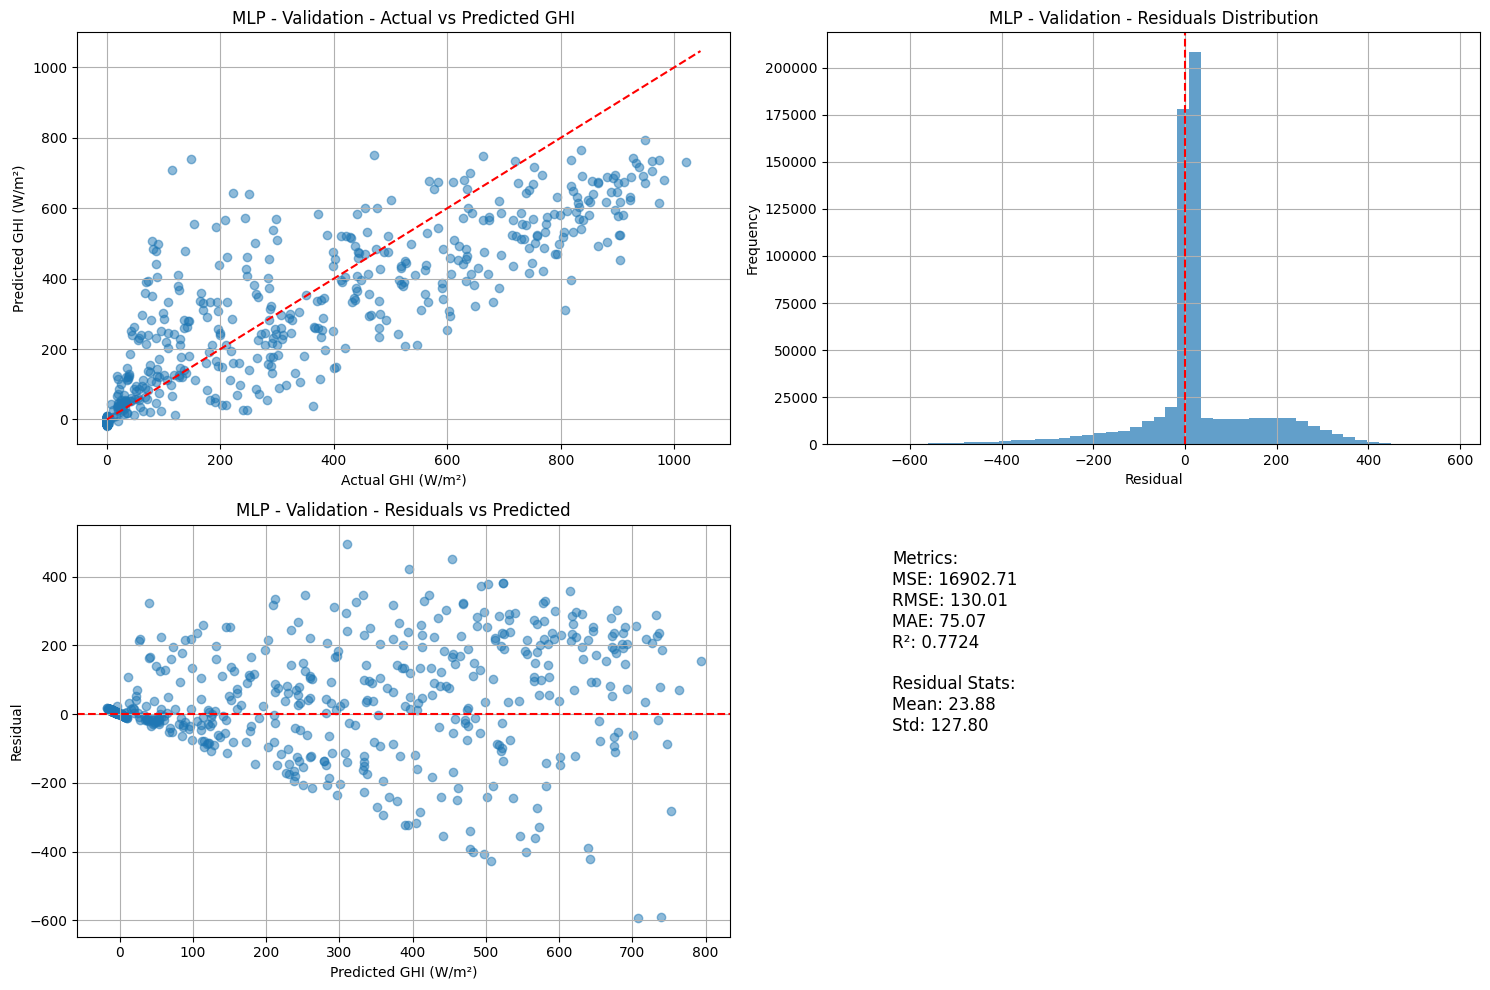


Evaluating MLP model on test set...
Evaluation Metrics:
  MSE: 14145.67
  RMSE: 118.94
  MAE: 66.24
  R²: 0.7768


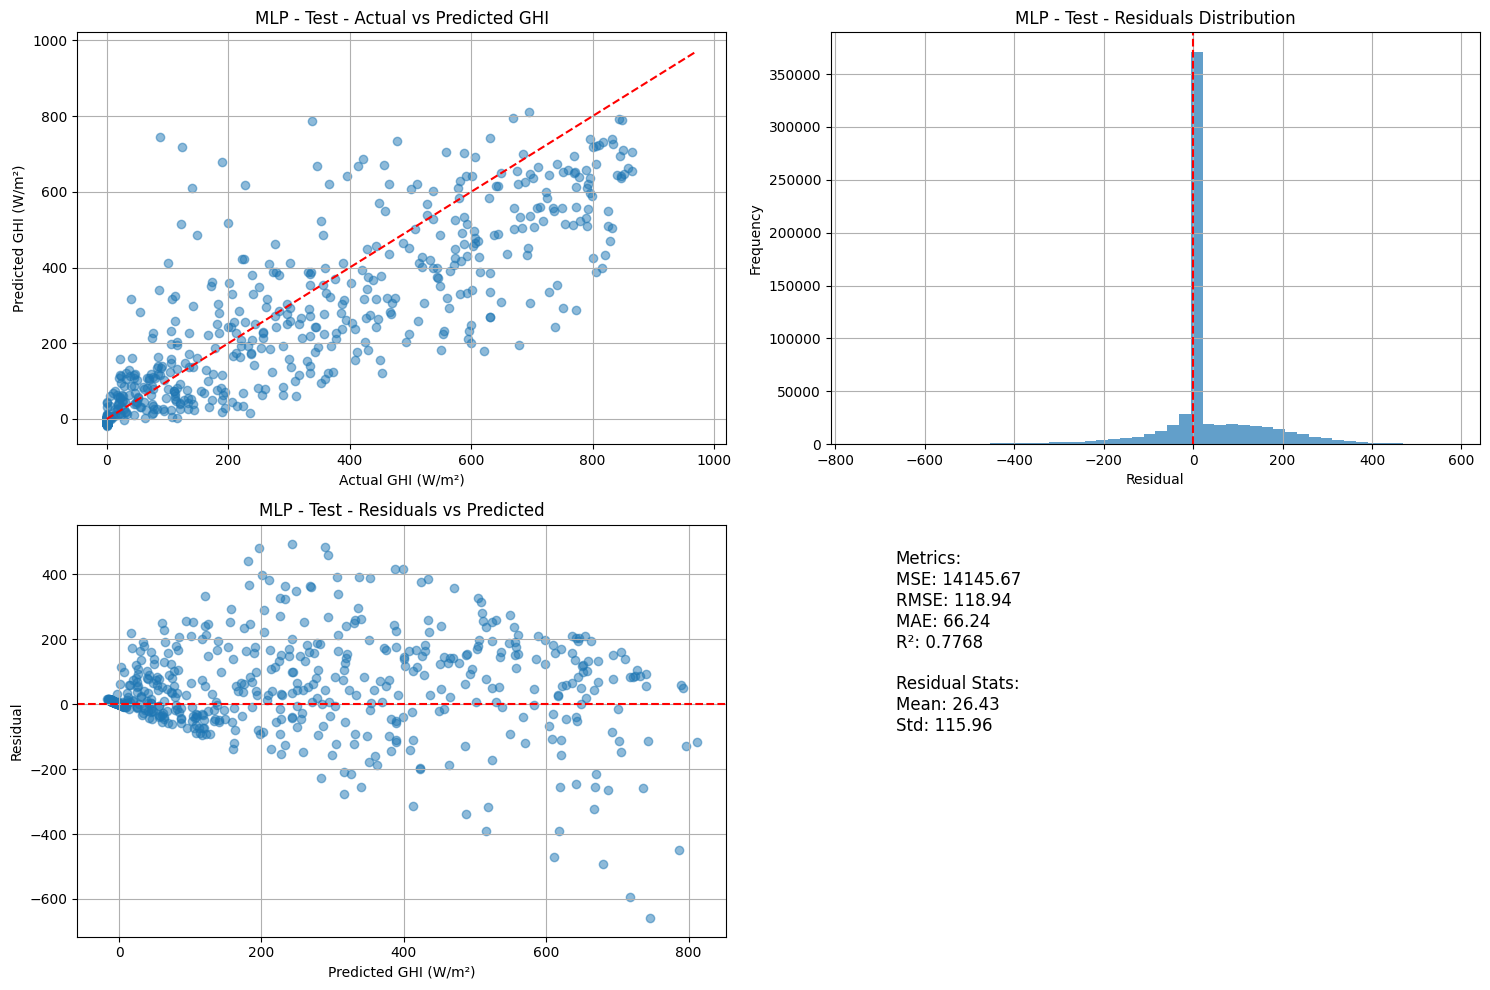

In [18]:
print("Training MLP model...")
mlp_history = train_model(mlp_model, train_loader, val_loader, epochs=50, patience=10, lr=0.001)
plot_training_history(mlp_history)

print("Evaluating MLP model on validation set...")
mlp_val_metrics = evaluate_model(mlp_model, val_loader, scalers['ghi_scaler'])
plot_predictions(mlp_val_metrics, model_name='MLP - Validation')

print("\nEvaluating MLP model on test set...")
mlp_test_metrics = evaluate_model(mlp_model, test_loader, scalers['ghi_scaler'])
plot_predictions(mlp_test_metrics, model_name='MLP - Test')


## 6. Model Comparison

Validation Set Comparison:
Model Comparison:
              LSTM      CNN-LSTM           MLP      PINN-MLP
MSE   19833.580078  19788.796875  16902.708984  15403.015625
RMSE    140.831744    140.672659    130.010419    124.108886
MAE      77.578499      80.78801     75.066055     67.764359
R²        0.732933      0.733536      0.772398      0.792592


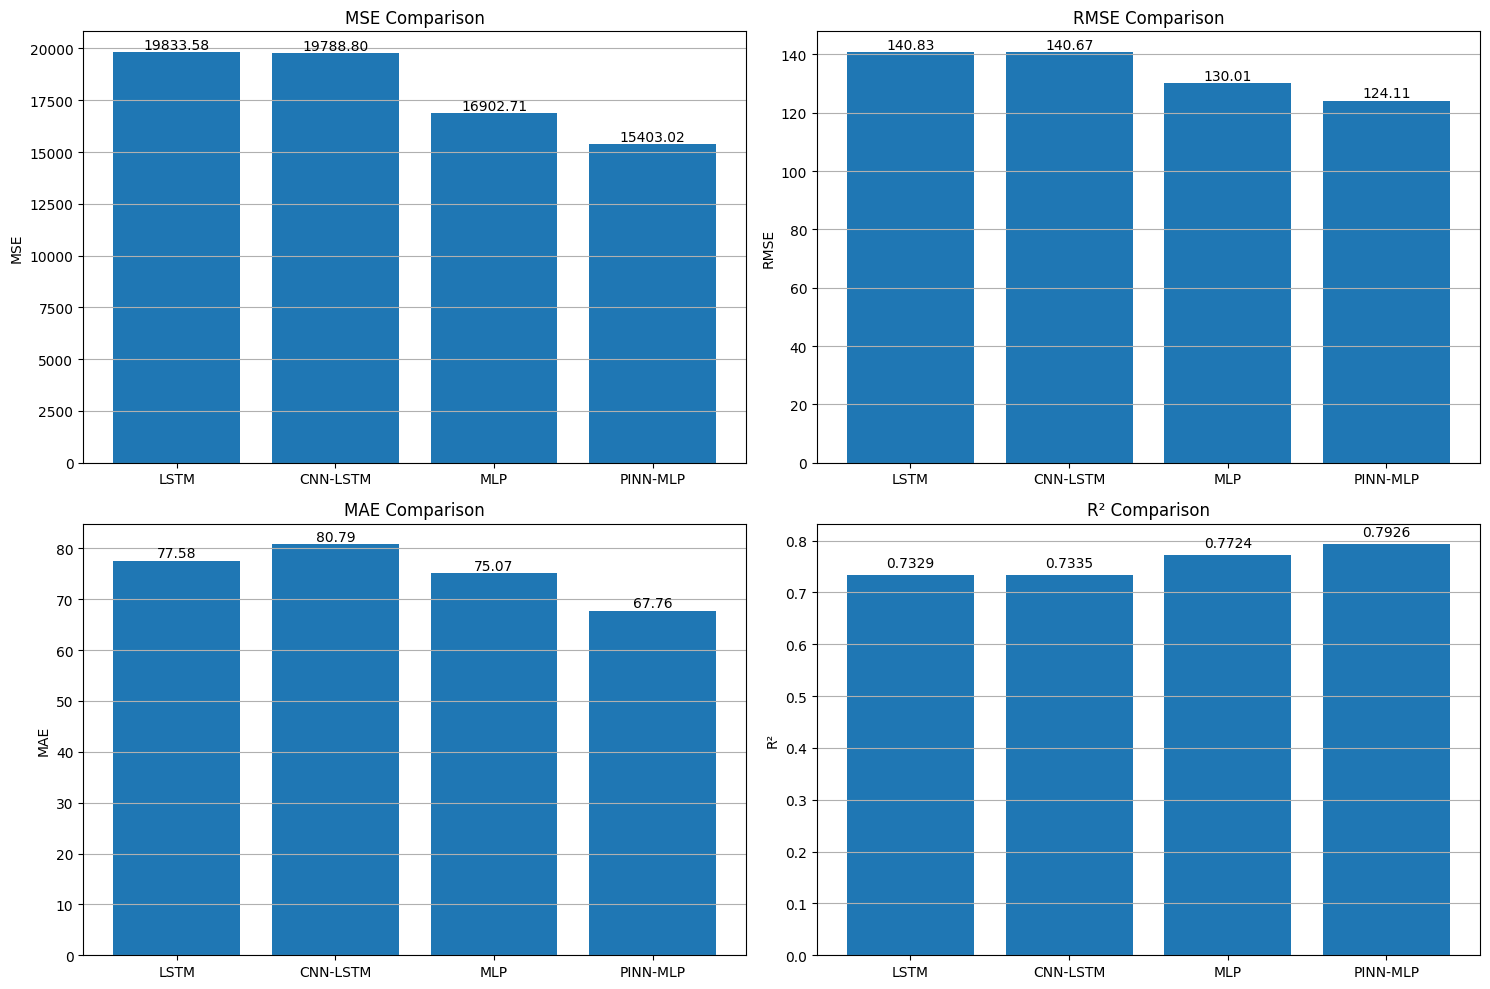


Test Set Comparison:
Model Comparison:
              LSTM     CNN-LSTM           MLP      PINN-MLP
MSE   16327.915039  13802.75293  14145.668945  11531.658203
RMSE     127.78073   117.485118    118.935566    107.385559
MAE      71.241776    65.156006     66.239288     57.131748
R²         0.74234     0.782188      0.776777      0.818027


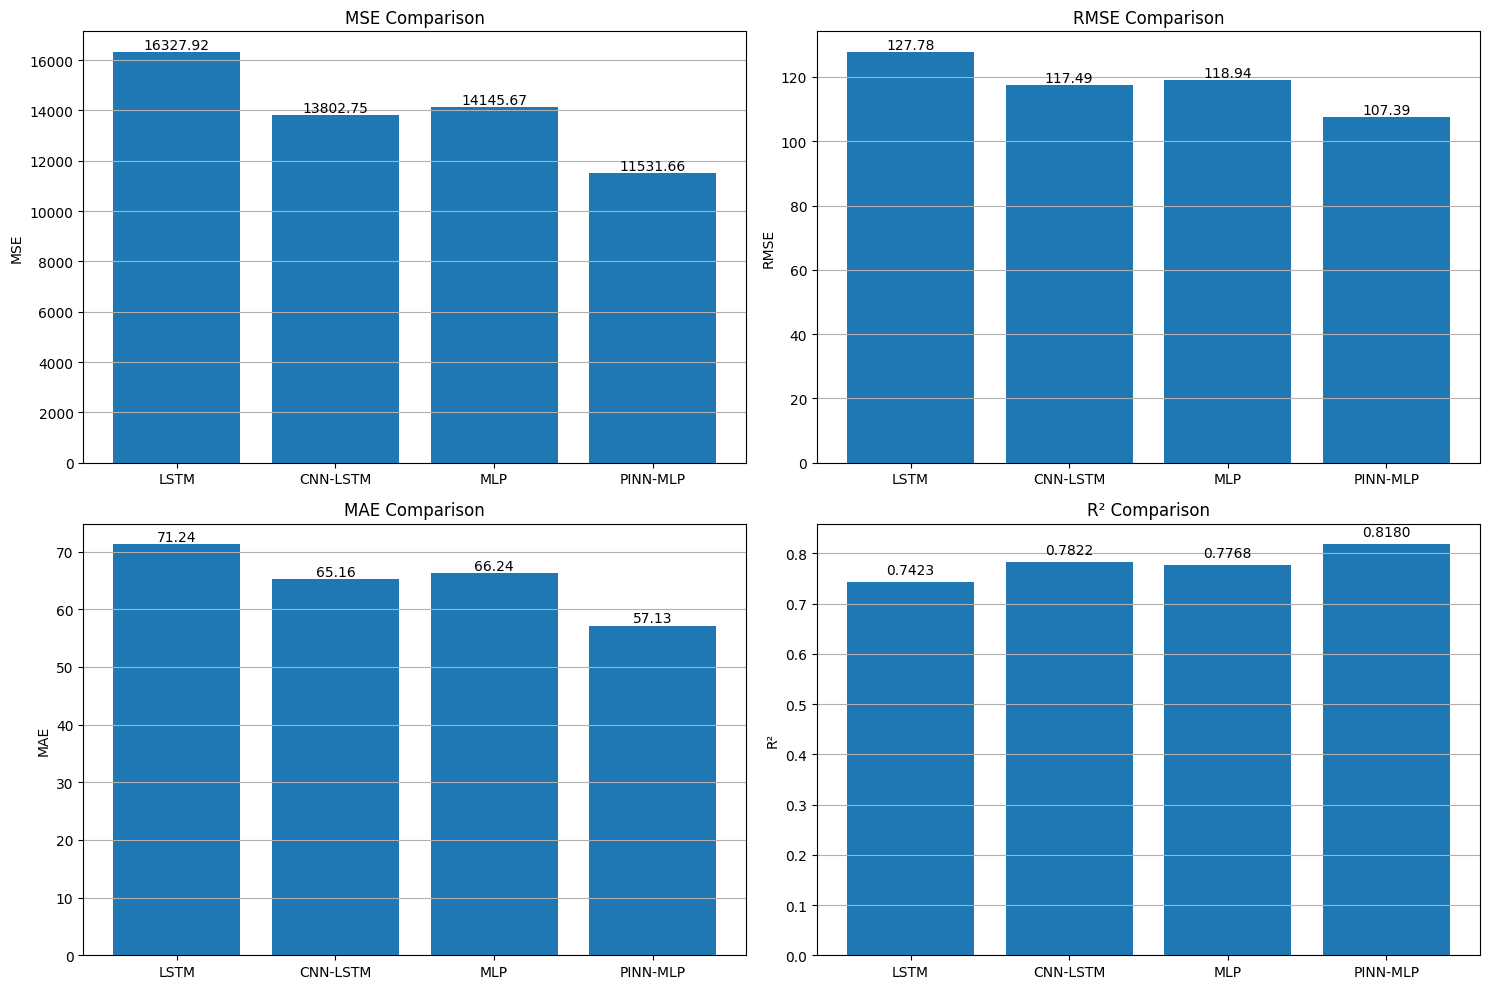

In [19]:
def compare_models(metrics_list, model_names):
    metrics = ['mse', 'rmse', 'mae', 'r2']
    metric_labels = ['MSE', 'RMSE', 'MAE', 'R²']
    comparison = pd.DataFrame(index=metric_labels, columns=model_names)

    for i, model_metrics in enumerate(metrics_list):
        for j, metric in enumerate(metrics):
            comparison.iloc[j, i] = model_metrics[metric]

    print("Model Comparison:")
    print(comparison)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for i, metric in enumerate(metrics):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        values = [metrics_dict[metric] for metrics_dict in metrics_list]
        bars = ax.bar(model_names, values)
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if metric == 'r2' else 0.1),
                    f"{value:.4f}" if metric == 'r2' else f"{value:.2f}", ha='center', va='bottom')
        ax.set_title(f'{metric_labels[i]} Comparison')
        ax.set_ylabel(metric_labels[i])
        ax.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

print("Validation Set Comparison:")
compare_models([lstm_val_metrics, cnn_lstm_val_metrics, mlp_val_metrics, pinn_mlp_val_metrics],
               ['LSTM', 'CNN-LSTM', 'MLP', 'PINN-MLP'])

print("\nTest Set Comparison:")
compare_models([lstm_test_metrics, cnn_lstm_test_metrics, mlp_test_metrics, pinn_mlp_test_metrics],
               ['LSTM', 'CNN-LSTM', 'MLP', 'PINN-MLP'])


### 6.1 Time Series Predictions

Visualize predictions over time, including the PINN-MLP model.

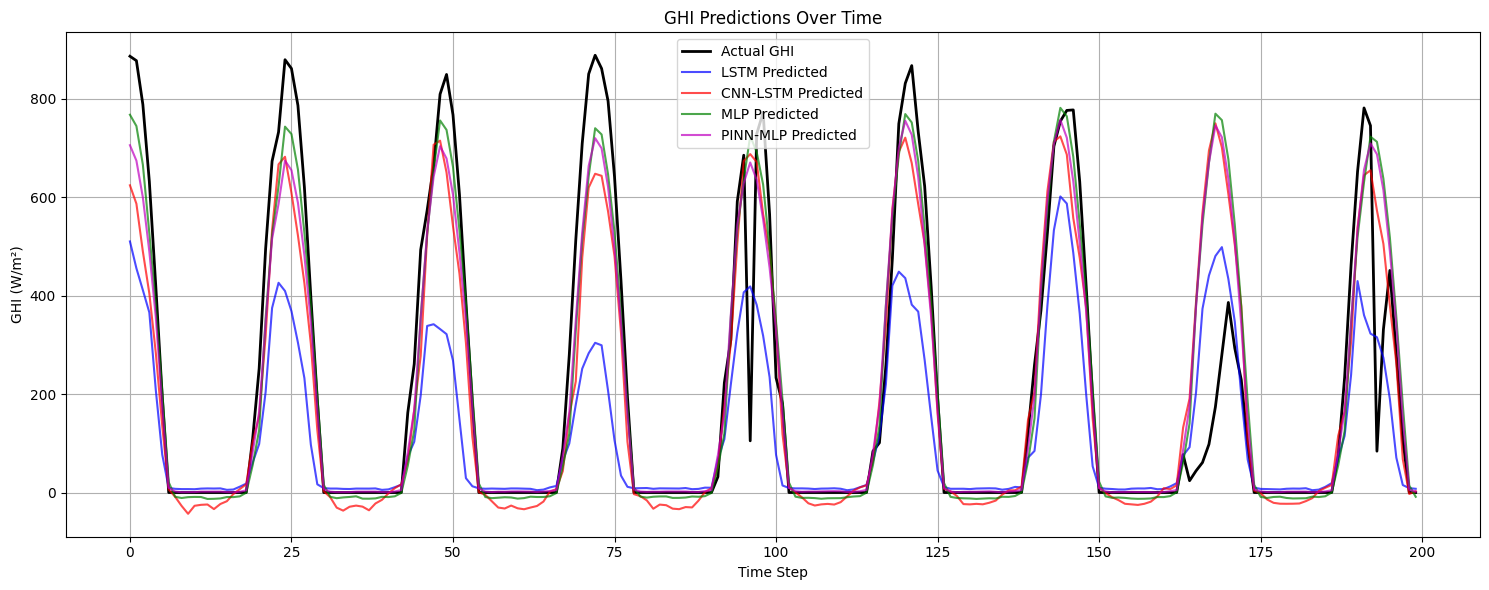

In [20]:
def plot_predictions_over_time(models, model_names, data_loader, scaler, num_samples=200, start_idx=0):
    all_features = []
    all_coords = []
    all_targets = []

    for batch in data_loader:
        all_features.extend(batch['features'])
        all_coords.extend(batch['coord'])
        all_targets.extend(batch['target'])
        if len(all_targets) >= start_idx + num_samples:
            break

    features = torch.stack(all_features[start_idx:start_idx+num_samples]).to(device)
    coords = torch.stack(all_coords[start_idx:start_idx+num_samples]).to(device)
    targets = torch.stack(all_targets[start_idx:start_idx+num_samples]).cpu().numpy()

    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(features, coords).cpu().numpy()
            predictions.append(outputs)

    y_true_orig = scaler.inverse_transform(targets)
    y_pred_orig_list = [scaler.inverse_transform(pred) for pred in predictions]

    plt.figure(figsize=(15, 6))
    plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)
    colors = ['b-', 'r-', 'g-', 'm-']
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        plt.plot(pred, colors[i], label=f'{name} Predicted', alpha=0.7)
    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('GHI (W/m²)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions_over_time(
    models=[lstm_model, cnn_lstm_model, mlp_model, pinn_mlp_model],
    model_names=['LSTM', 'CNN-LSTM', 'MLP', 'PINN-MLP'],
    data_loader=test_loader,
    scaler=scalers['ghi_scaler'],
    num_samples=200,
    start_idx=100
)


## 7. Conclusion

This notebook implemented four deep learning models for GHI forecasting:

1. **LSTM Model**: Captures long-term temporal dependencies.
2. **CNN-LSTM Model**: Combines local pattern extraction with temporal modeling.
3. **MLP Model**: Processes flattened time series with static features.
4. **PINN-MLP Model**: Enhances MLP with a physics-informed loss to enforce zero GHI at night.

### Key Findings

- The PINN-MLP model incorporates physical constraints, potentially improving generalization.
- Performance varies across models, with trade-offs in complexity and accuracy.
- Spatial and temporal features enhance model capability.

### Future Improvements

- Tune `lambda_phys` in PINN-MLP for optimal balance.
- Incorporate additional physical constraints (e.g., clear-sky models).
- Explore ensemble methods and multi-step forecasting.

In [21]:
torch.save(lstm_model.state_dict(), 'lstm_ghi_forecasting_model.pt')
torch.save(cnn_lstm_model.state_dict(), 'cnn_lstm_ghi_forecasting_model.pt')
torch.save(mlp_model.state_dict(), 'mlp_ghi_forecasting_model.pt')
torch.save(pinn_mlp_model.state_dict(), 'pinn_mlp_ghi_forecasting_model.pt')
print("Models saved successfully.")


Models saved successfully.
